In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [88]:
customer_json_file ='Datos_SIATA_Aire_pm25.json'
customers_json = pd.read_json(customer_json_file, convert_dates=True)

In [89]:
def aqi(df):
    l_aqi = []
    #completar denominaciones
    concentraciones=df["valor"]
    l_quality = []
    for concentracion in concentraciones:
        if(concentracion<12):
            quality = "Good"
            conc_lo=0.0
            conc_hi=12.0
            aqi_lo=0.0
            aqi_hi=50
        elif(concentracion>12 and concentracion<=35.4):
            quality = "Moderate"
            conc_lo=12.1
            conc_hi=35.4
            aqi_lo=51
            aqi_hi=100
        elif(concentracion>35.4 and concentracion<=55.5):
            quality = "Unhealthy-SensitiveGroups"
            conc_lo=35.5
            conc_hi=55.4
            aqi_lo=101
            aqi_hi=150
        elif(concentracion>55.4 and concentracion<=150.4):
            quality = "Unhealthy"
            conc_lo=55.5
            conc_hi=150.4
            aqi_lo=151
            aqi_hi=200
        elif(concentracion>150.4 and concentracion<=250.4):
            quality = "Very Unhealthy"
            conc_lo=150.5
            conc_hi=250.4
            aqi_lo=201
            aqi_hi=300
        if(concentracion>250.4):
            quality = "Hazardous"
            conc_lo=250.5
            conc_hi=500.4
            aqi_lo=301
            aqi_hi=500
        aqi_equation = ((aqi_hi-aqi_lo)/(conc_hi-conc_lo)*(concentracion-conc_lo))+(aqi_lo)
        l_aqi.append(aqi_equation)
        l_quality.append(quality)
    df_aqi= pd.DataFrame({"aqi":l_aqi,"quality":l_quality})
    df_final = pd.concat([df.reset_index(),df_aqi],axis=1)
    df_final = df_final.drop(df_final.columns[[0, 1]], axis=1)
    return df_final
    

In [125]:
def transform_data(df):
    l_aux = []
    for fila in range(len(df)):
        df_datos_prueba = pd.DataFrame(df.iloc[fila]["datos"])
        df_adicional = pd.DataFrame(df.iloc[fila])
        df_adicional = df_adicional.transpose()
        df_adicional = df_adicional.drop("datos", axis=1)
        df_adicional = pd.concat([df_adicional] * len(df_datos_prueba))
        df_final = pd.concat([df_adicional.reset_index(), df_datos_prueba], axis=1)
        l_aux.append(df_final)

    dataframe_final = pd.concat(l_aux, ignore_index=True)
    dataframe_final = dataframe_final.drop(["codigoSerial", "nombreCorto", "variableConsulta", "calidad"], axis=1)
    dataframe_final['fecha'] = pd.to_datetime(dataframe_final['fecha'])
    dataframe_final['latitud'] = dataframe_final['latitud'].astype('float64')
    dataframe_final['longitud'] = dataframe_final['longitud'].astype('float64')
    dataframe_final = dataframe_final.query("0 <= valor <= 500")
    
    # Crear una nueva columna "hora" que contiene solo la hora de la fecha
    dataframe_final['hora'] = dataframe_final['fecha'].dt.time
    
    dataframe_final = aqi(dataframe_final)
    
    return dataframe_final


In [122]:
def obtener_registros_por_dia(dataframe, dia):
    dia = pd.to_datetime(dia).date()
    registros_dia = dataframe[dataframe['fecha'].dt.date == dia]
    return registros_dia

def obtener_registros_por_hora(dataframe, fecha_hora):
    fecha_hora = pd.to_datetime(fecha_hora)
    registros_hora = dataframe[dataframe['fecha'] == fecha_hora]
    return registros_hora

In [126]:
df_final=transform_data(customers_json)

C:\Users\FELIPE~1.LAP\AppData\Local\Temp/ipykernel_14740/2785491055.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_final['hora'] = dataframe_final['fecha'].dt.time


Apply transformations

In [164]:
def graph_valor(dataframe):
    from scipy.interpolate import griddata
    # Definir las coordenadas de latitud y longitud en el DataFrame
    lat = dataframe['latitud']
    lon = dataframe['longitud']
    valores = dataframe['valor']
    # Crear un grid de coordenadas de latitud y longitud
    latitud_grid = np.linspace(lat.min(), lat.max(), 100)  # Ajusta la resolución según tus necesidades
    longitud_grid = np.linspace(lon.min(), lon.max(), 100)  # Ajusta la resolución según tus necesidades
    latitud_mesh, longitud_mesh = np.meshgrid(latitud_grid, longitud_grid)

    # Realizar interpolación cúbica de los valores de PM2.5 en el grid
    grid_interpolado_cubico = griddata((lat, lon), valores, (latitud_mesh, longitud_mesh), method='cubic')

    # Encontrar los puntos en los que la interpolación cúbica no tiene valores
    puntos_faltantes = np.isnan(grid_interpolado_cubico)

    # Realizar interpolación de vecinos más cercanos en los puntos faltantes
    grid_interpolado_vecinos = griddata((lat, lon), valores, (latitud_mesh, longitud_mesh), method='nearest')

    # Combinar las interpolaciones: usar la cúbica donde esté disponible y los vecinos más cercanos donde falte
    grid_interpolado_combinado = np.where(puntos_faltantes, grid_interpolado_vecinos, grid_interpolado_cubico)

    # Crear un gráfico de contorno del resultado combinado
    plt.figure(figsize=(12, 8))
    plt.contourf(latitud_mesh, longitud_mesh, grid_interpolado_combinado, cmap='viridis')  # Puedes cambiar el mapa de colores
    plt.colorbar(label='Valor de PM2.5')
    plt.xlabel('Latitud')
    plt.ylabel('Longitud')
    plt.title('Interpolación Cúbica con Vecinos Más Cercanos en Sectores Faltantes')

    # Mostrar el gráfico
    plt.show()
        

In [159]:
def graph_aqi(dataframe):
    from scipy.interpolate import griddata
    
    # Definir las coordenadas de latitud y longitud en el DataFrame
    lat = dataframe['latitud']
    lon = dataframe['longitud']
    aqi = dataframe['aqi']  # Cambiamos de 'valor' a 'aqi'
    
    # Crear un grid de coordenadas de latitud y longitud
    latitud_grid = np.linspace(lat.min(), lat.max(), 100)  # Ajusta la resolución según tus necesidades
    longitud_grid = np.linspace(lon.min(), lon.max(), 100)  # Ajusta la resolución según tus necesidades
    latitud_mesh, longitud_mesh = np.meshgrid(latitud_grid, longitud_grid)

    # Realizar interpolación cúbica de los valores de AQI en el grid
    grid_interpolado_cubico = griddata((lat, lon), aqi, (latitud_mesh, longitud_mesh), method='cubic')

    # Encontrar los puntos en los que la interpolación cúbica no tiene valores
    puntos_faltantes = np.isnan(grid_interpolado_cubico)

    # Realizar interpolación de vecinos más cercanos en los puntos faltantes
    grid_interpolado_vecinos = griddata((lat, lon), aqi, (latitud_mesh, longitud_mesh), method='nearest')

    # Combinar las interpolaciones: usar la cúbica donde esté disponible y los vecinos más cercanos donde falte
    grid_interpolado_combinado = np.where(puntos_faltantes, grid_interpolado_vecinos, grid_interpolado_cubico)

    # Crear un gráfico de contorno del resultado combinado
    plt.figure(figsize=(12, 8))
    plt.contourf(latitud_mesh, longitud_mesh, grid_interpolado_combinado, cmap='viridis')  
    plt.colorbar(label='AQI')
    plt.xlabel('Latitud')
    plt.ylabel('Longitud')
    plt.title('Interpolación Cúbica con Vecinos Más Cercanos en Sectores Faltantes para AQI')

    # Mostrar el gráfico
    plt.show()


In [160]:
df_prueba=obtener_registros_por_hora(df_final,"2020-02-21 00:00:00")

In [170]:
import matplotlib.pyplot as plt

def animate_aqi_evolution(dataframe):
    # Obtiene una lista única de fechas
    fechas_unicas = dataframe['fecha'].dt.date.unique()
    
    # Define el rango de colores para los valores de AQI
    cmap = plt.get_cmap('viridis')
    
    for fecha in fechas_unicas:
        # Filtra los registros para la fecha actual
        registros_dia = obtener_registros_por_dia(dataframe, fecha)
        
        # Inicializa la figura
        plt.figure(figsize=(12, 8))
        plt.title(f'AQI Evolution for {fecha}')
        plt.xlabel('Latitud')
        plt.ylabel('Longitud')
        
        # Recorre las horas del día
        for hora in range(24):
            # Filtra los registros para la hora actual
            hora_str = f'{hora:02d}:00:00'
            registros_hora = registros_dia[registros_dia['hora'] == hora_str]
            
            # Si hay registros, grafica el AQI
            if not registros_hora.empty:
                latitudes = registros_hora['latitud']
                longitudes = registros_hora['longitud']
                aqi_values = registros_hora['aqi']
                
                # Crea un scatter plot con colores basados en el AQI
                plt.scatter(
                    longitudes, latitudes, c=aqi_values, cmap=cmap, s=20, alpha=0.7,
                    label=f'{hora_str}', edgecolors='w', linewidths=0.5
                )
                
                plt.legend(loc='upper right')
                plt.title(f'AQI Evolution for {fecha} - {hora_str}')
                plt.xlabel('Latitud')
                plt.ylabel('Longitud')
                
                # Agrega una barra de colores
                cbar = plt.colorbar()
                cbar.set_label('AQI Value')
                
                # Pausa para mostrar la gráfica actual
                plt.pause(0.01)
                
        # Cierra la figura al final de cada día
        plt.close()

# Llama a la función con tu dataframe



In [171]:
animate_aqi_evolution(df_final)

In [186]:
fecha_hora_unicas = df_final['fecha'].sort_values().unique()


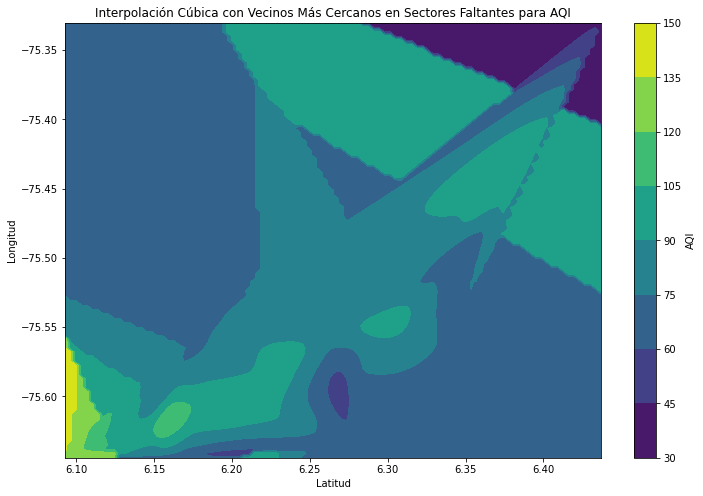

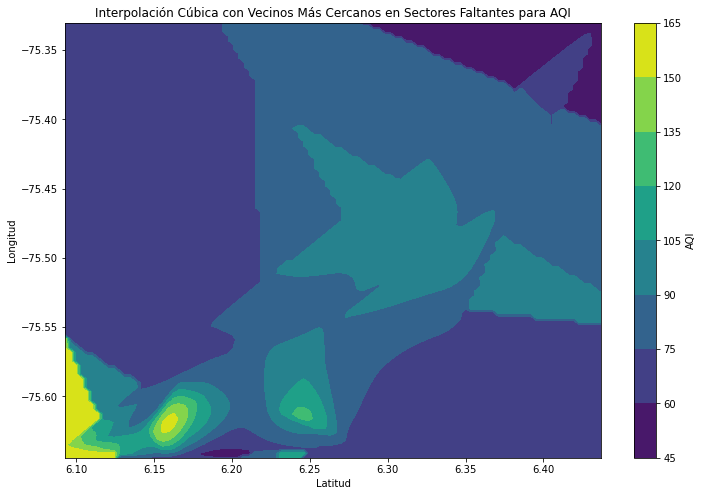

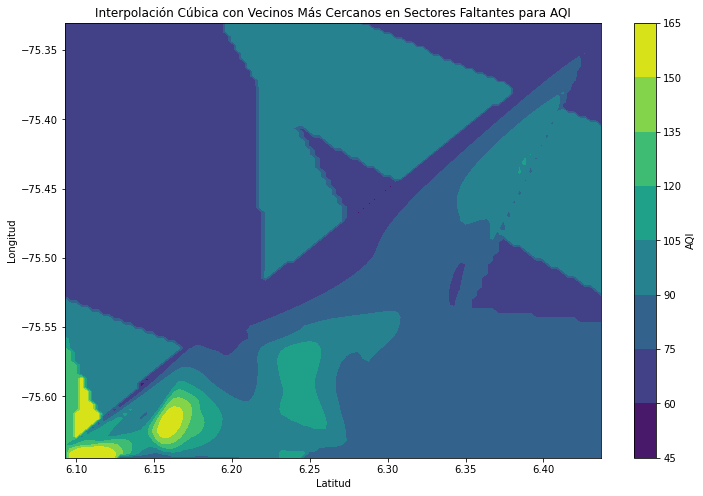

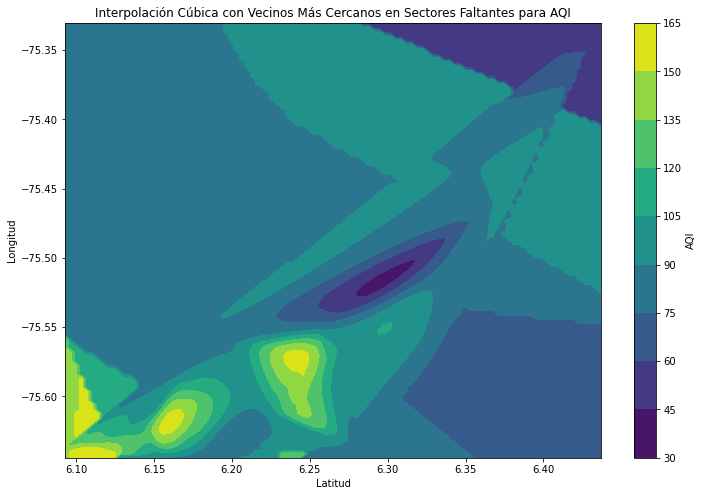

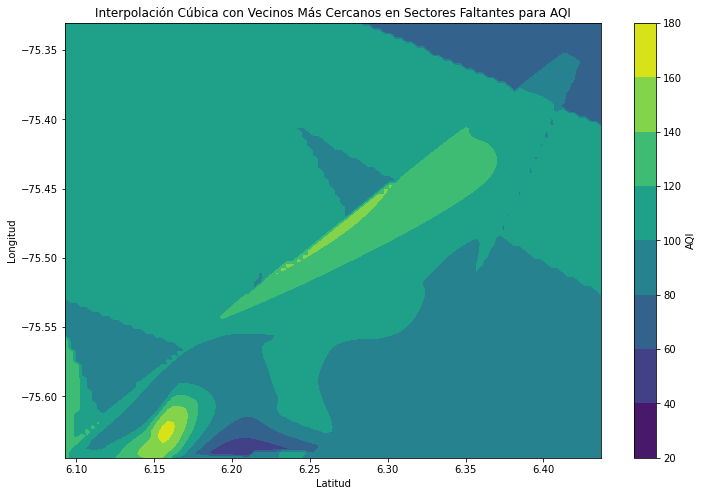

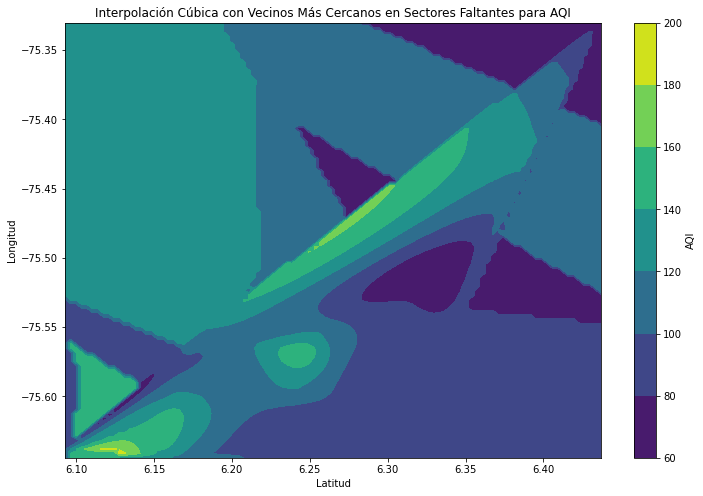

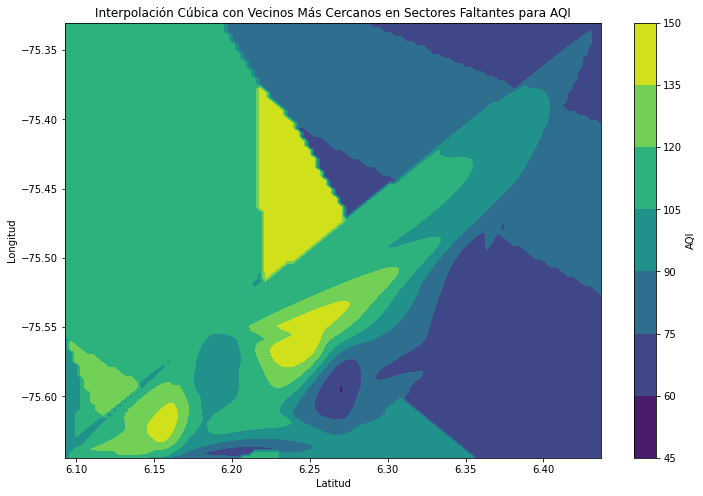

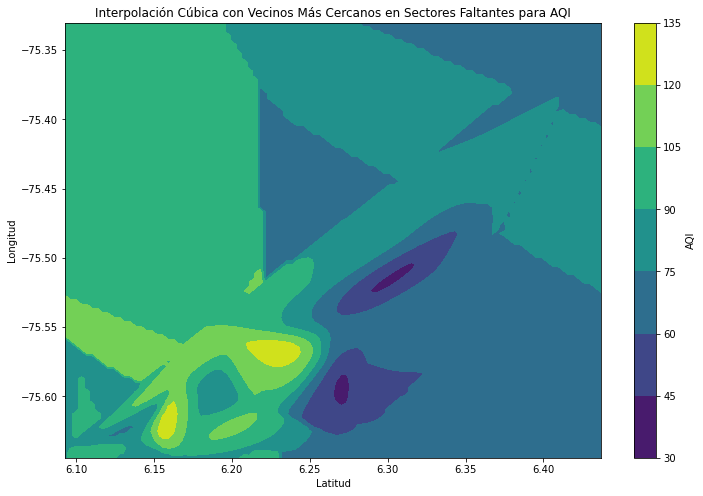

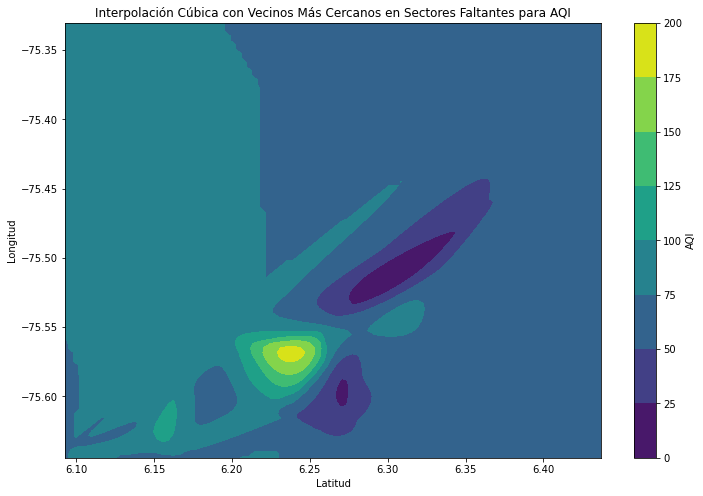

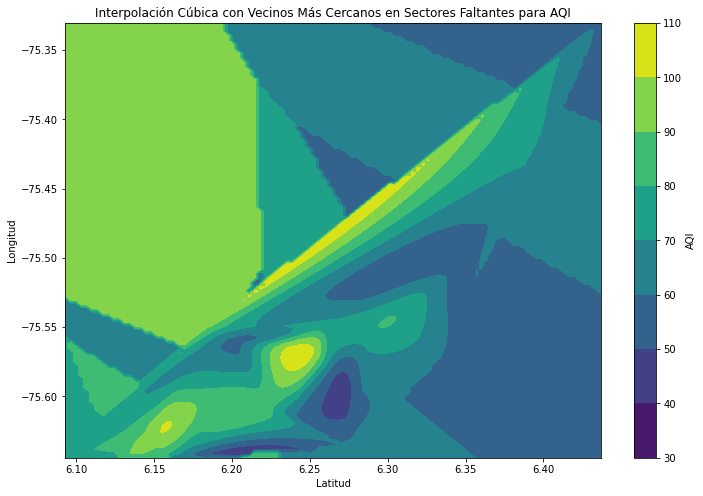

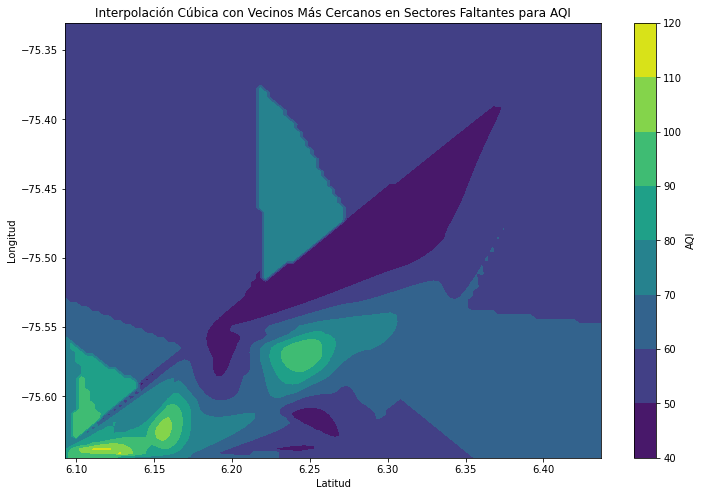

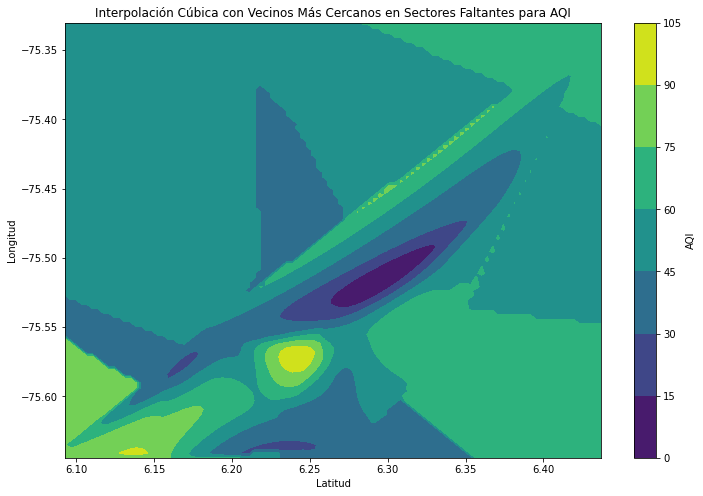

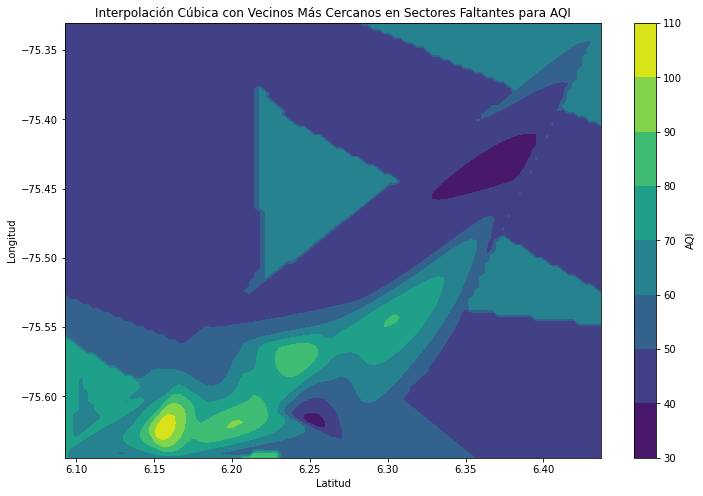

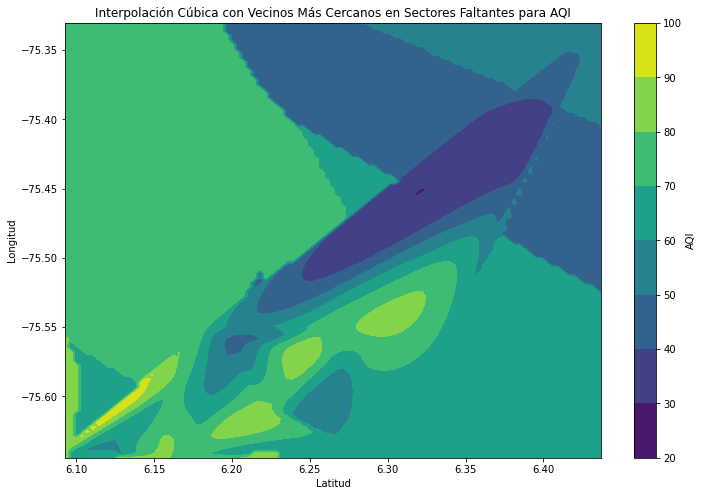

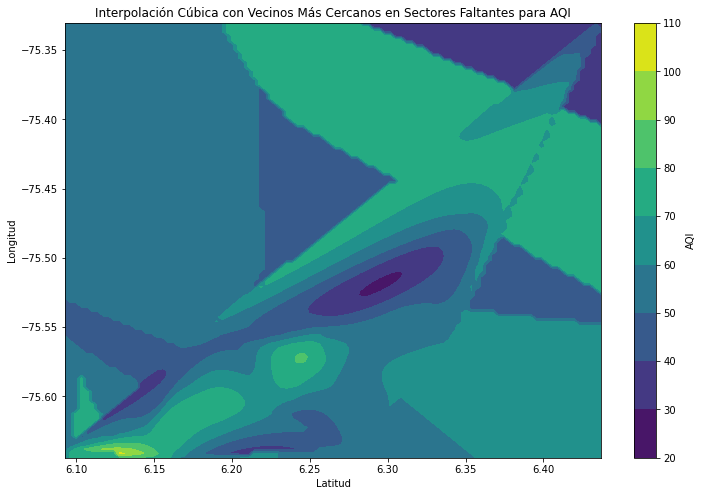

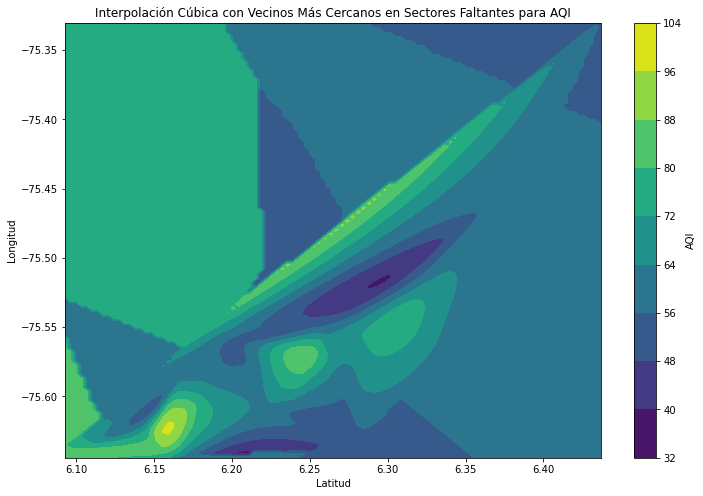

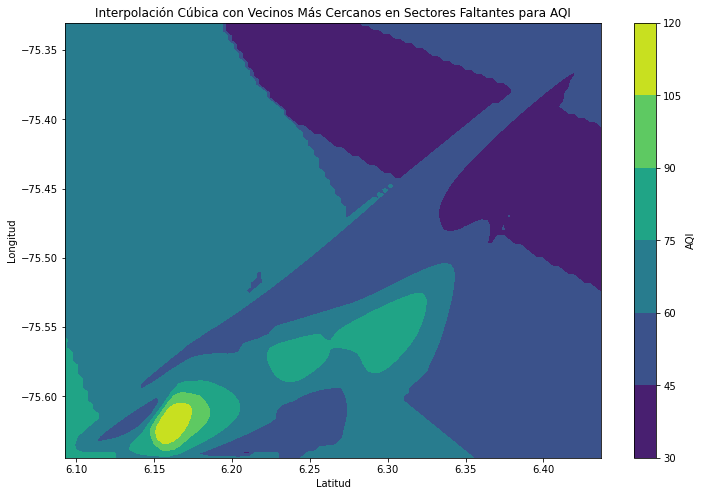

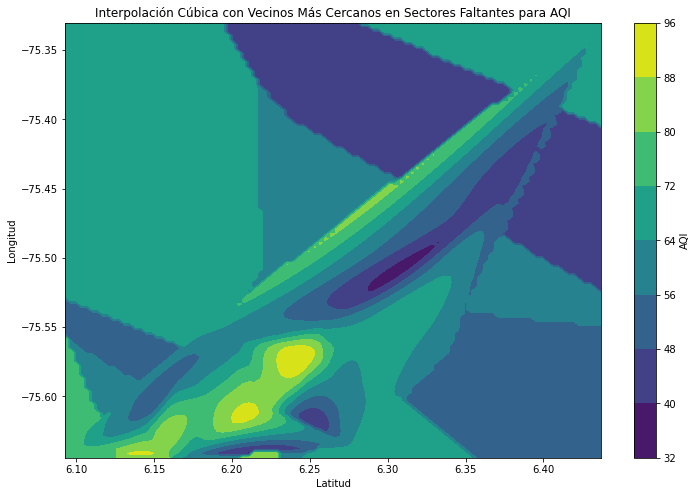

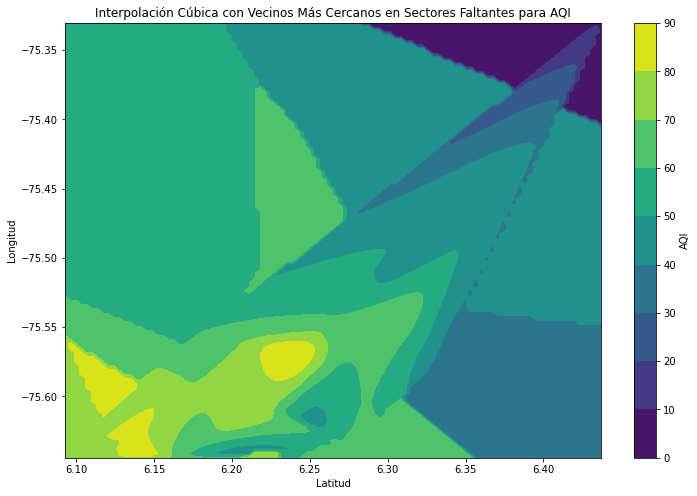

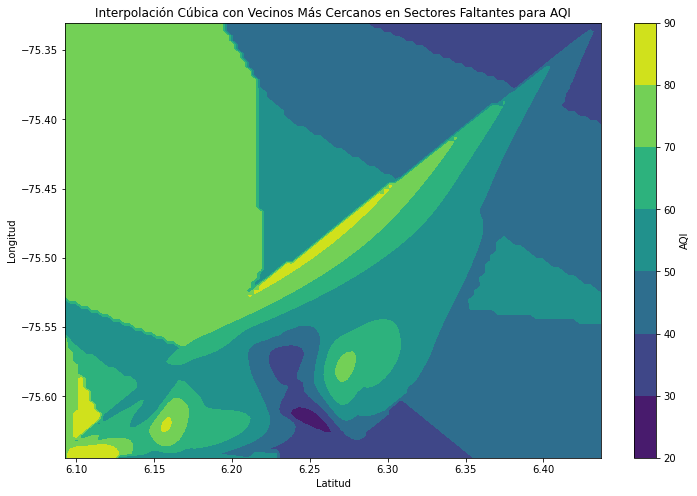

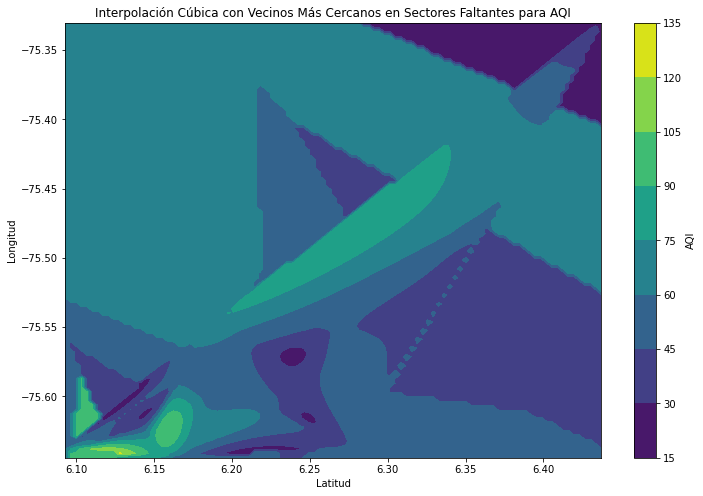

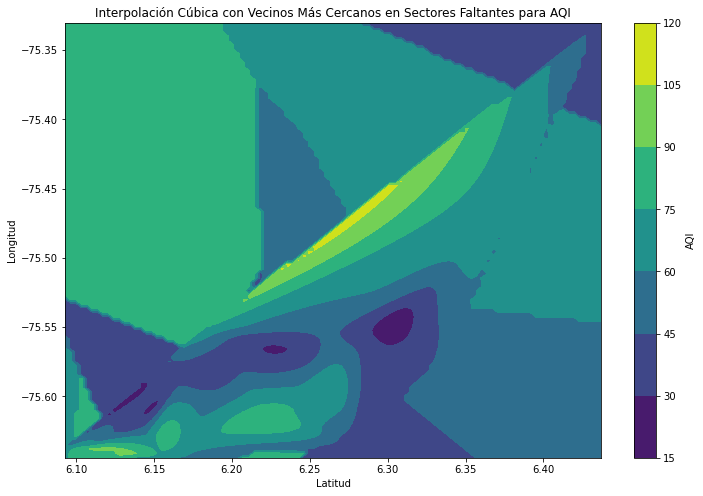

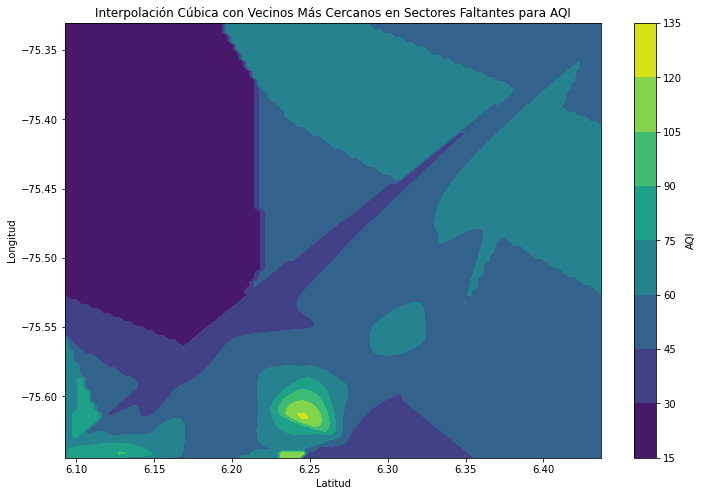

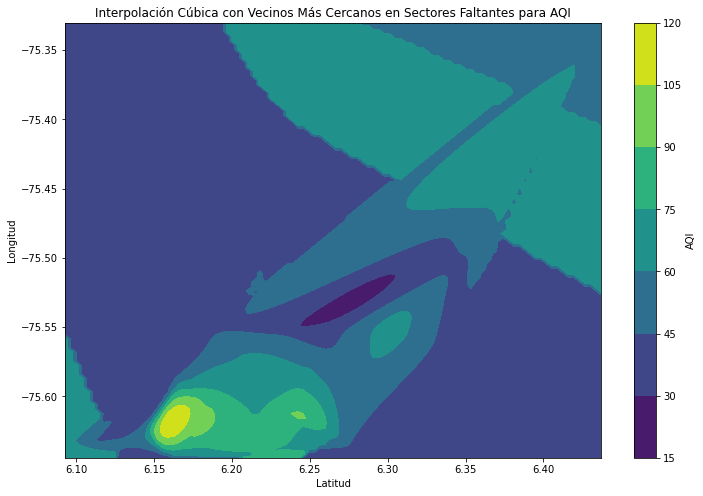

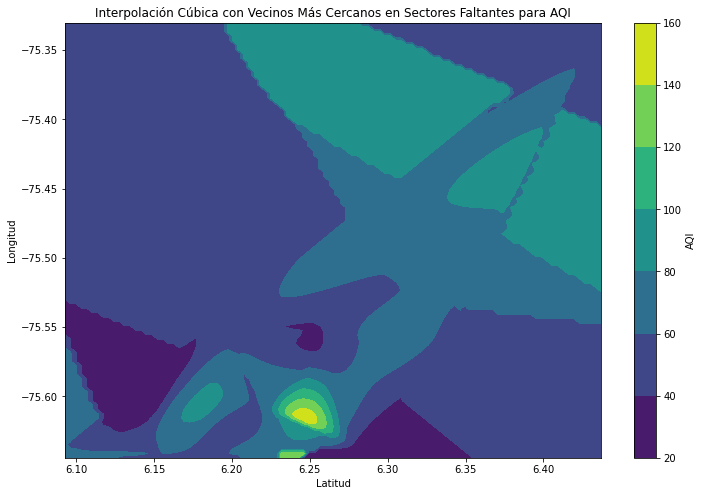

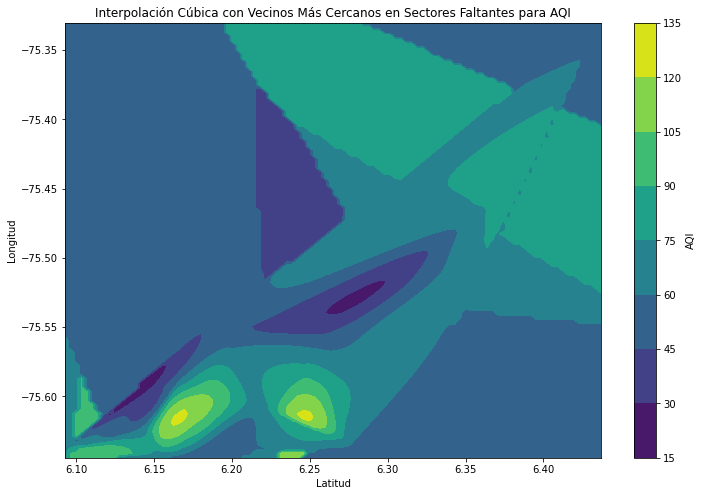

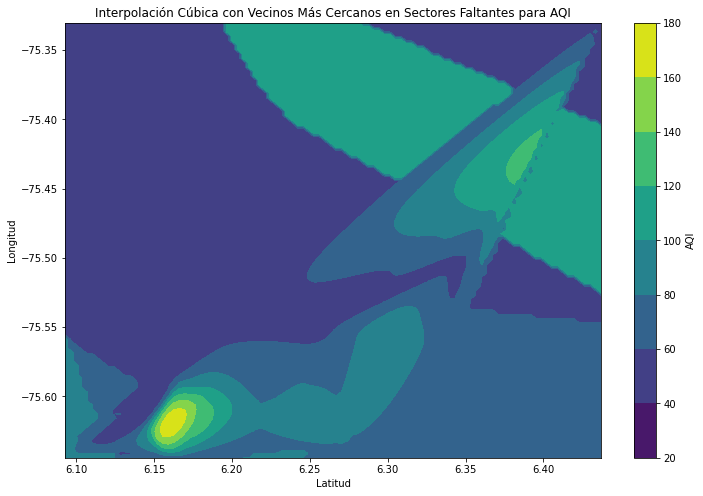

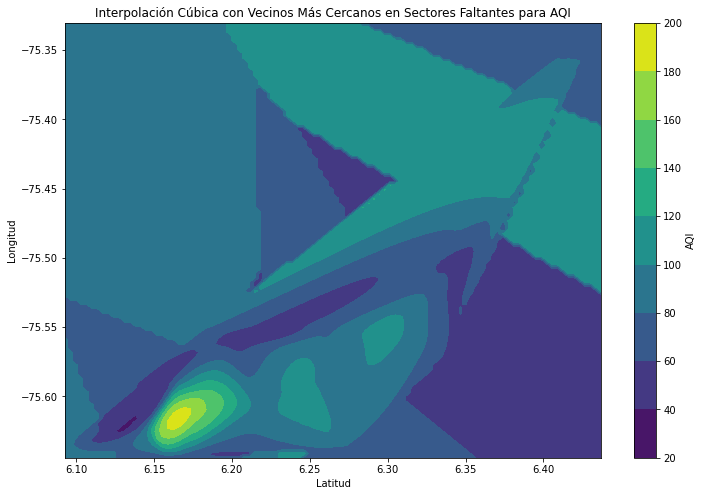

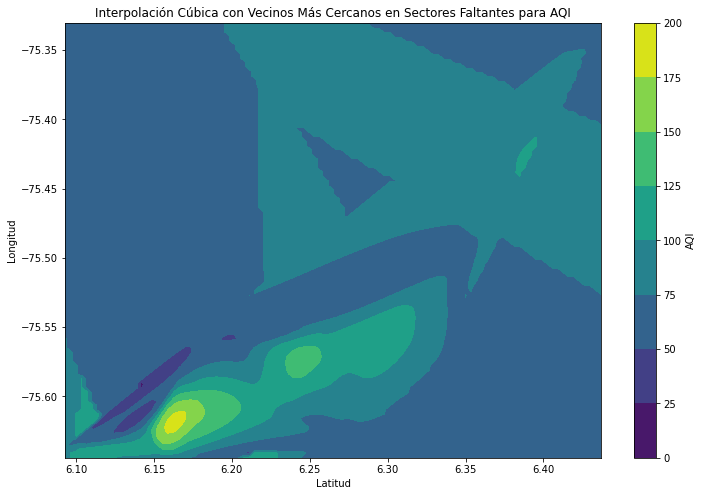

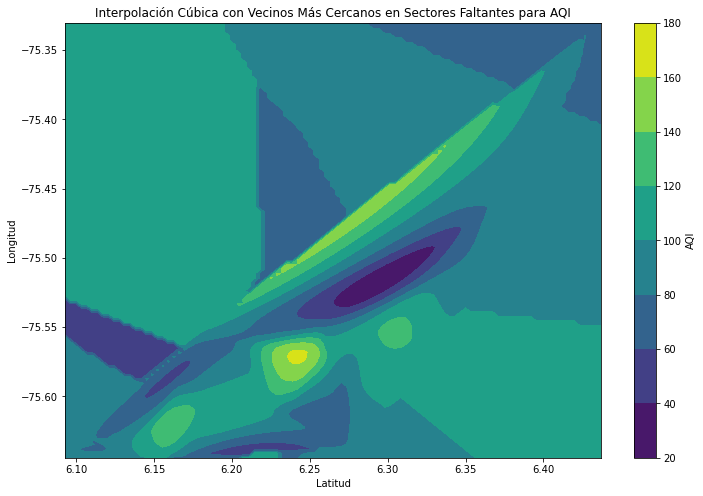

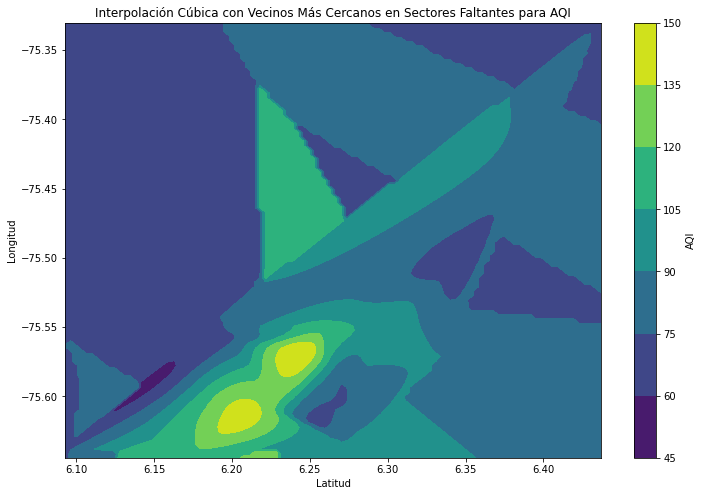

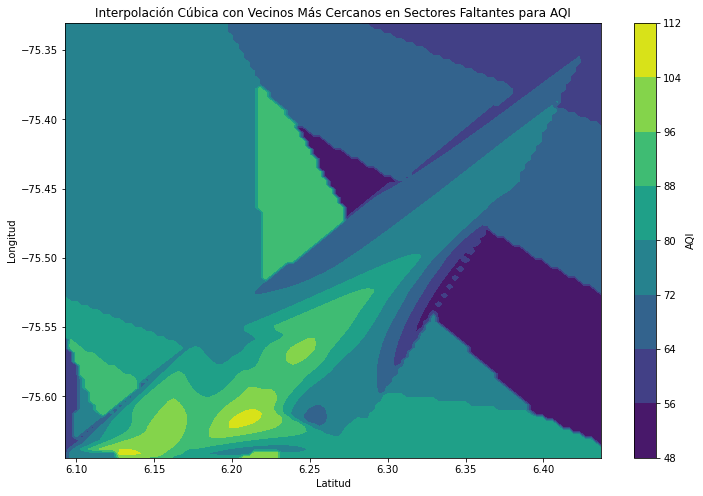

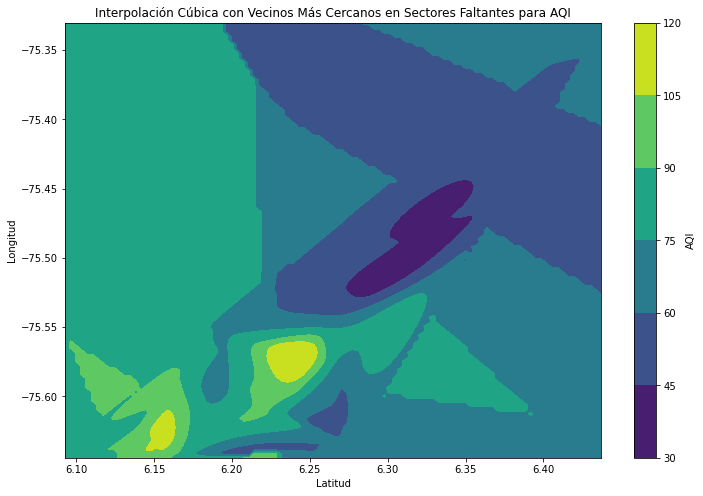

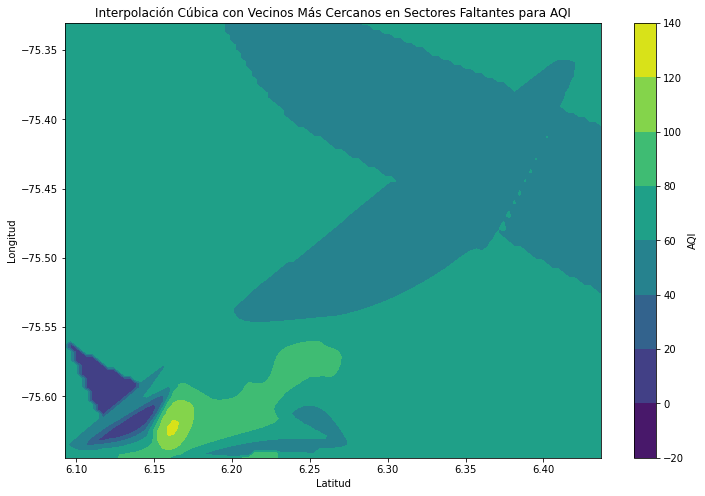

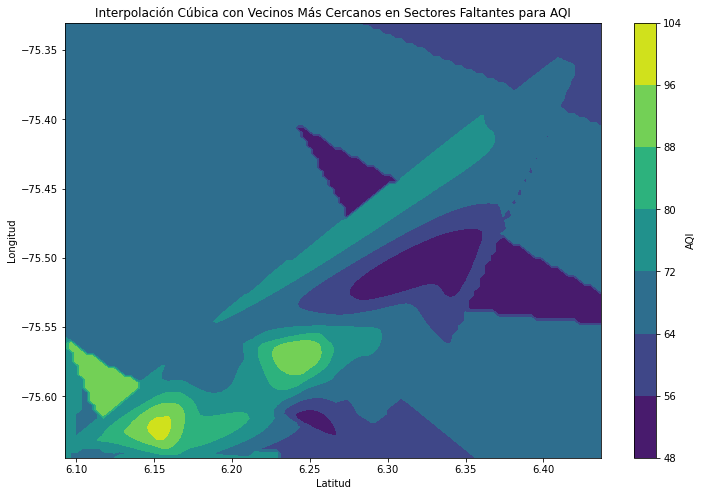

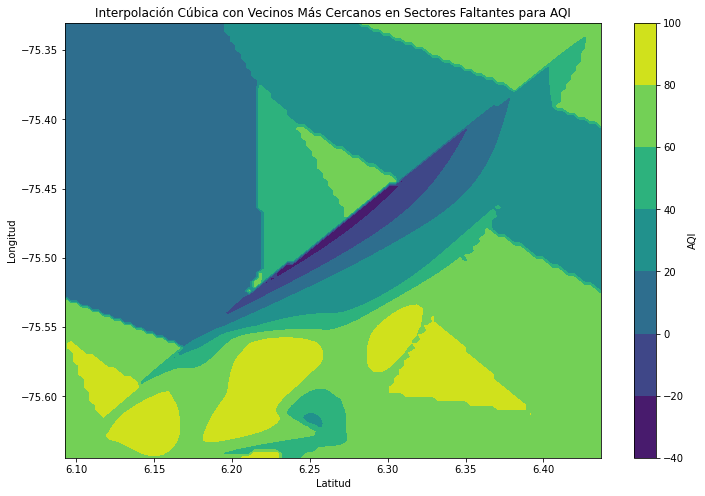

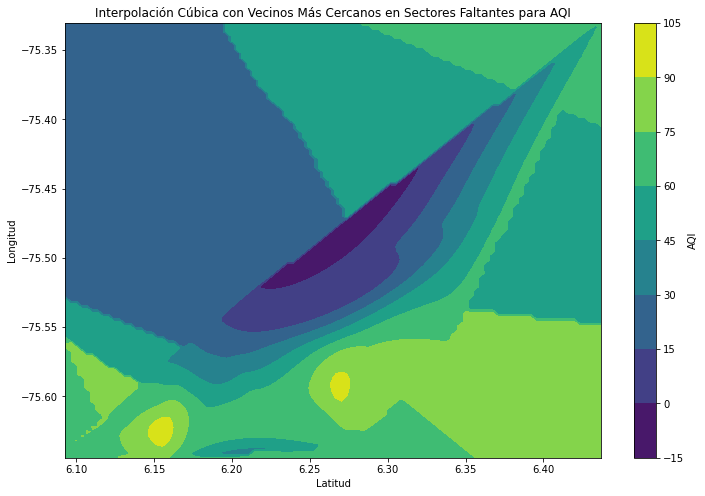

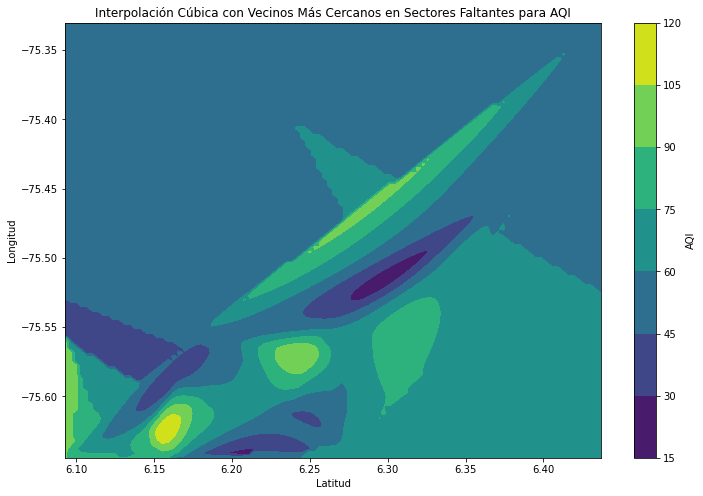

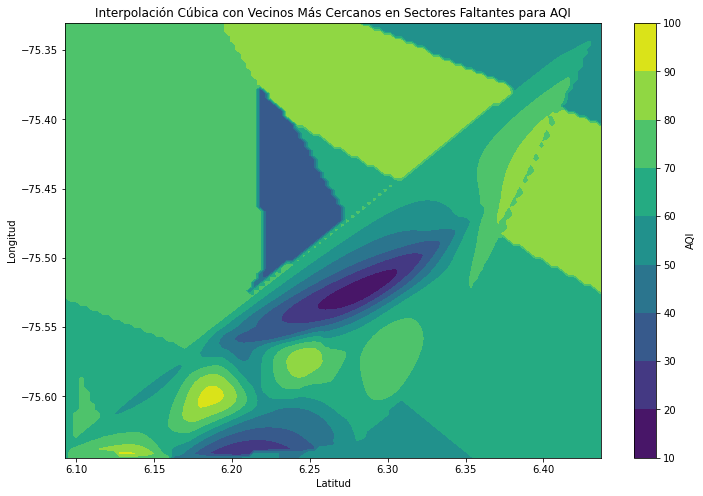

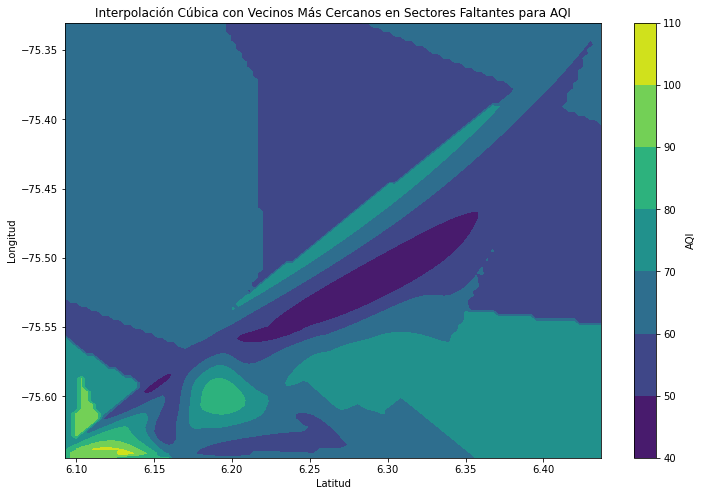

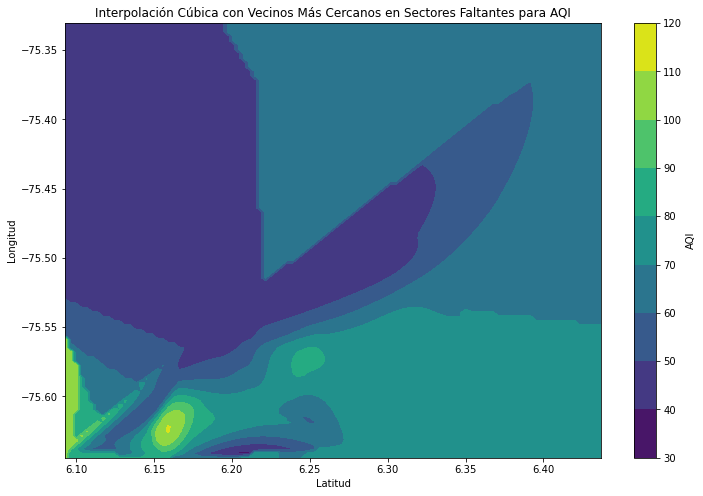

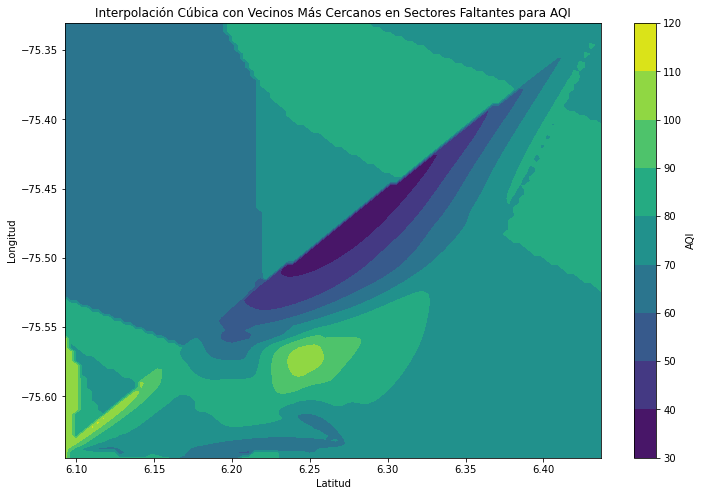

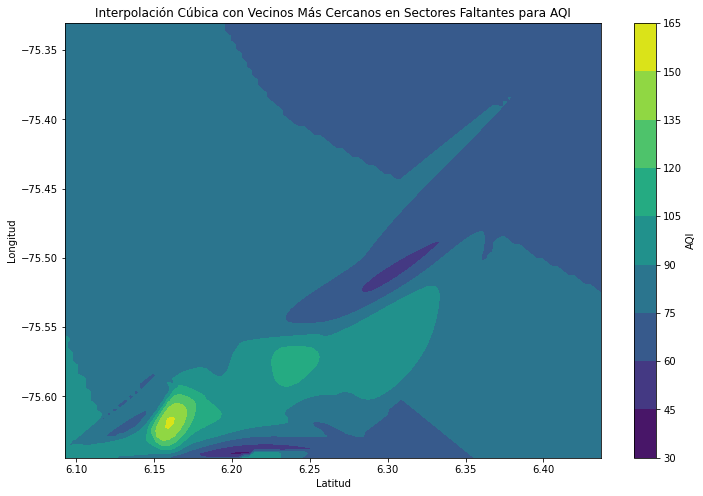

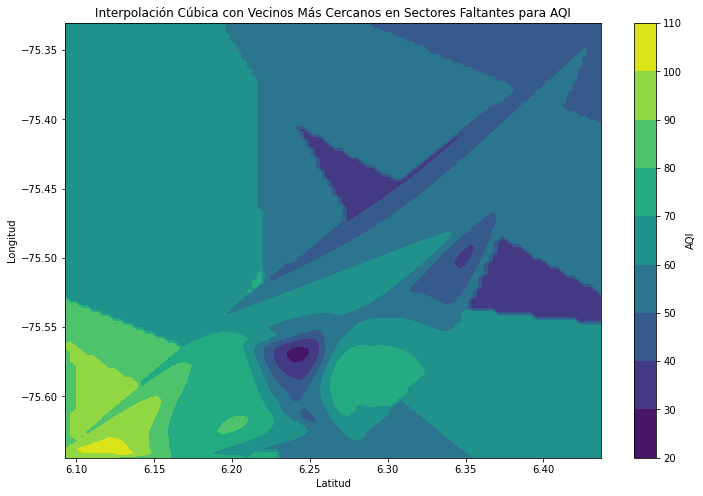

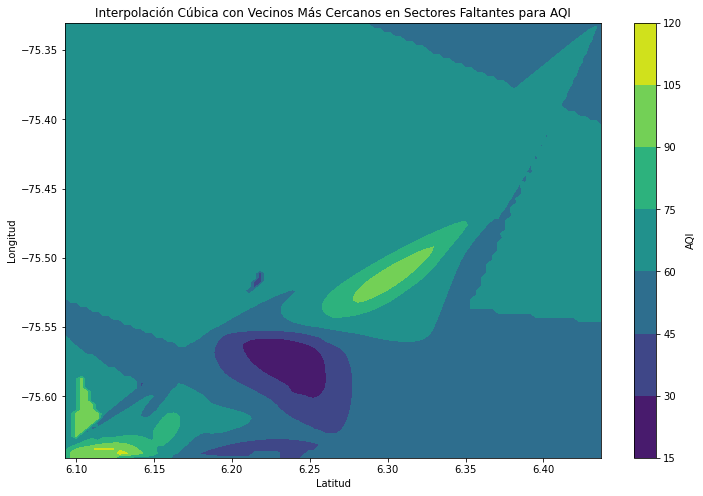

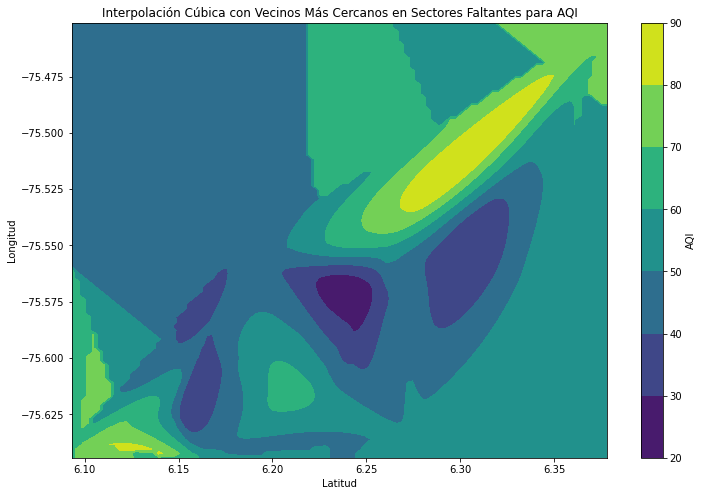

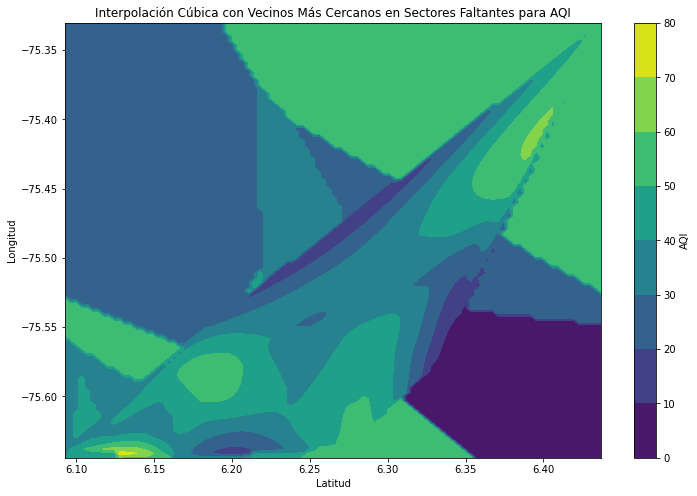

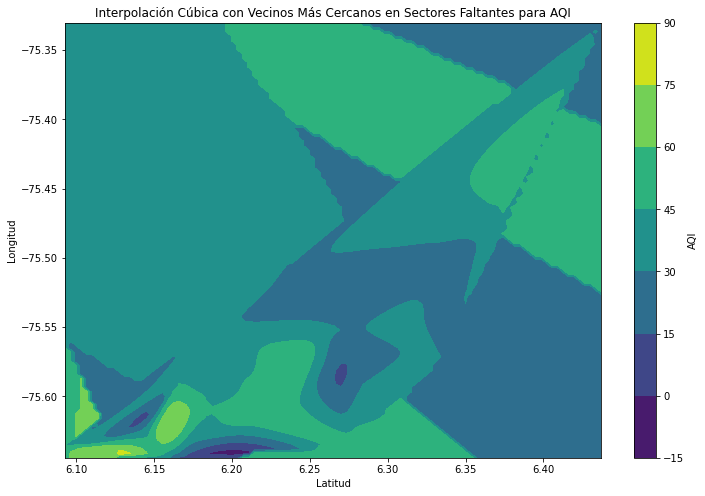

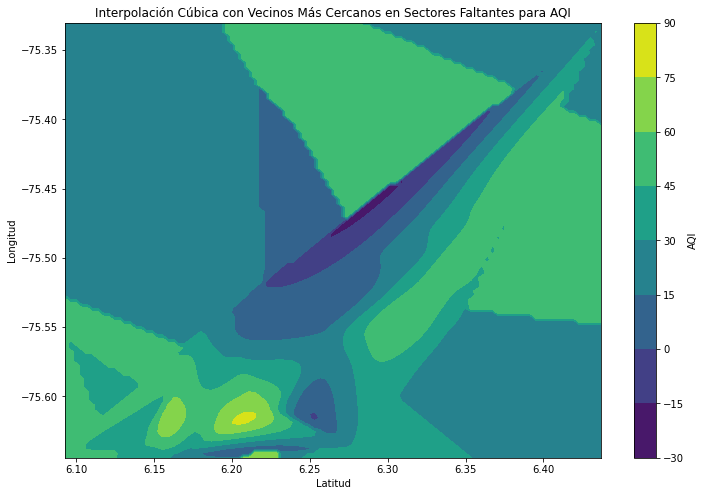

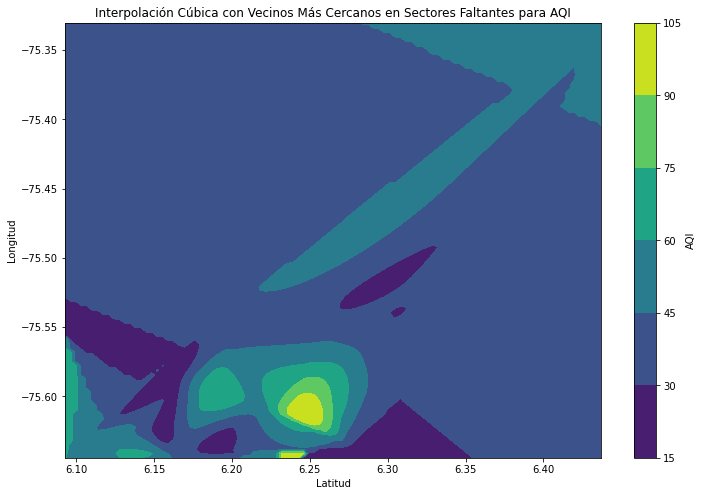

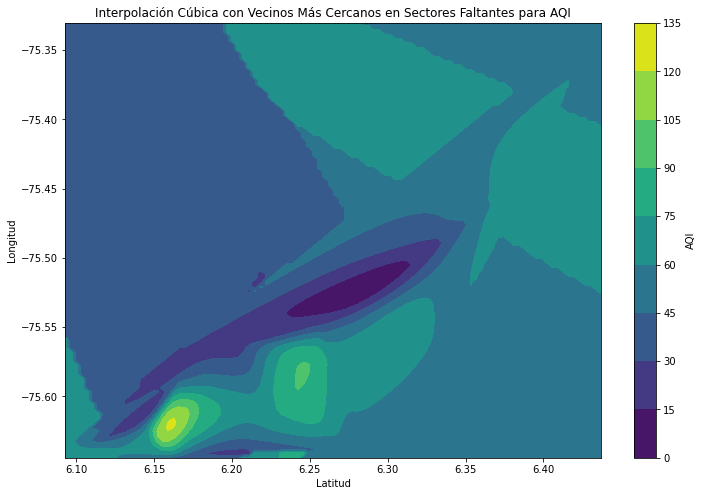

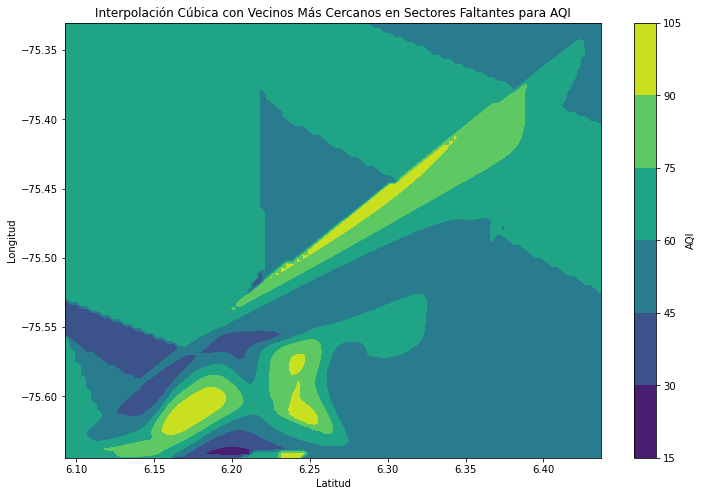

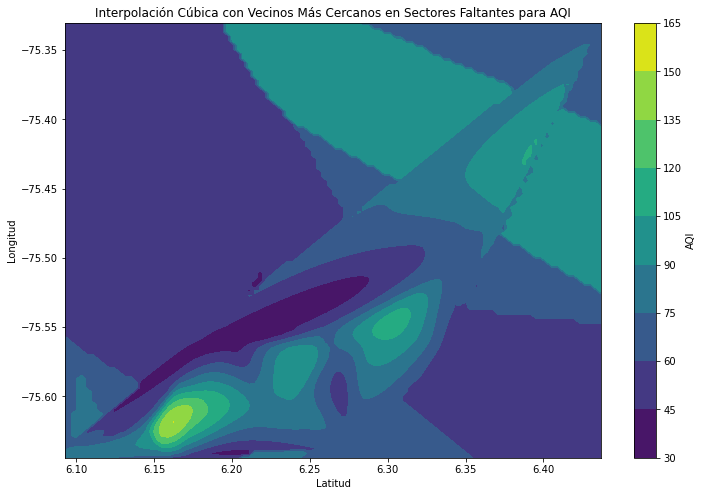

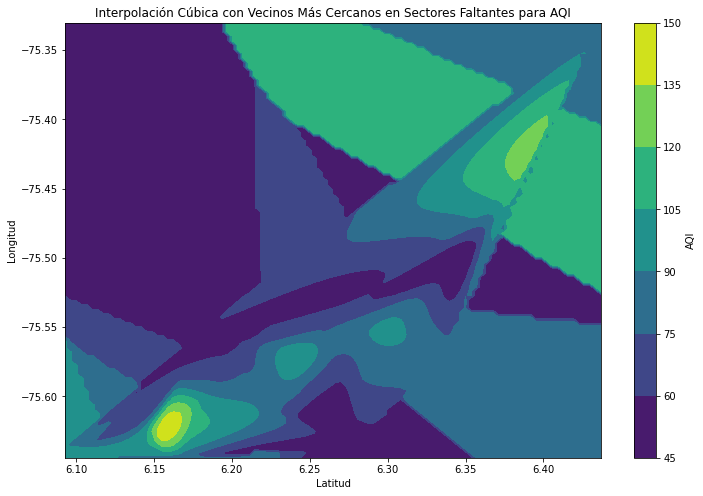

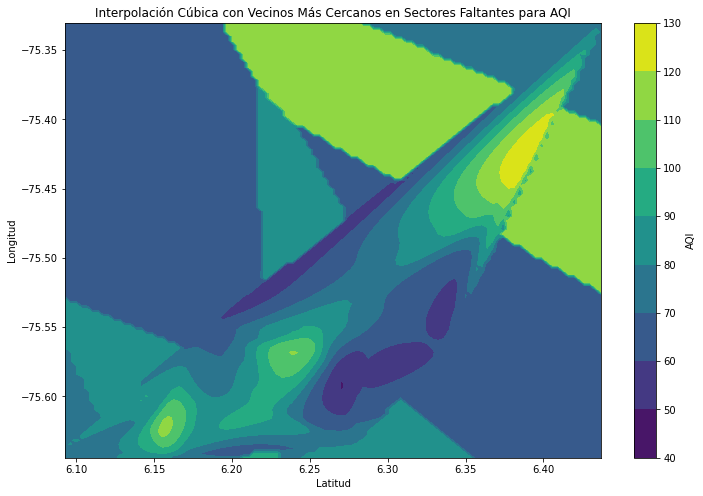

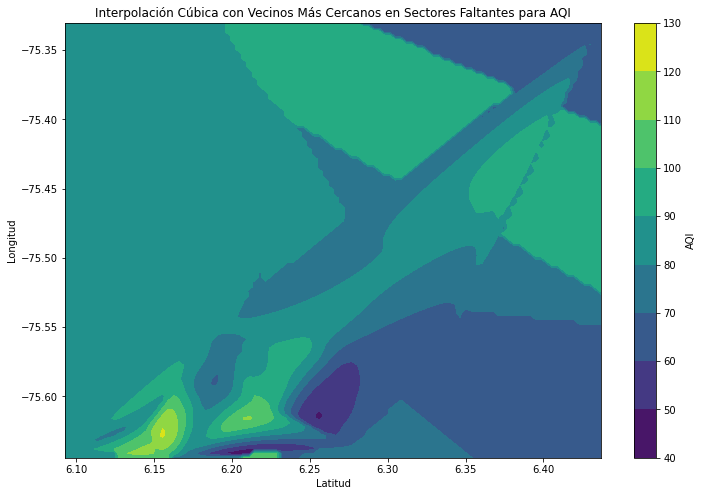

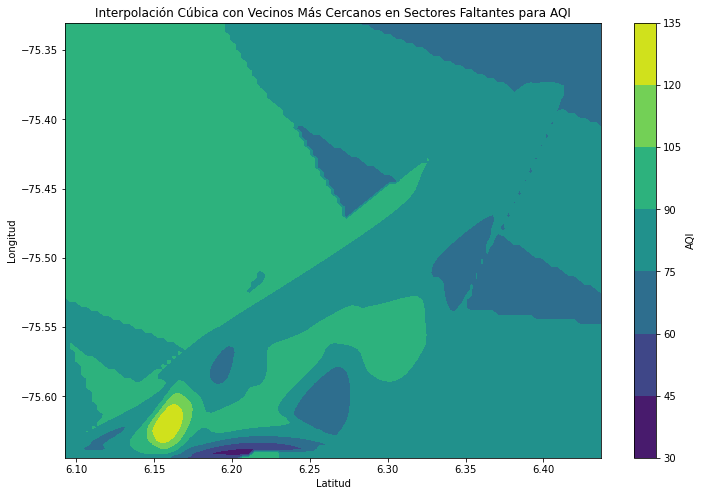

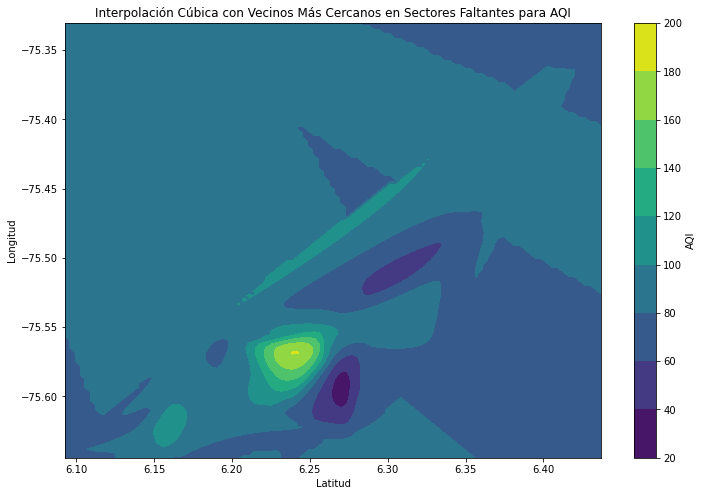

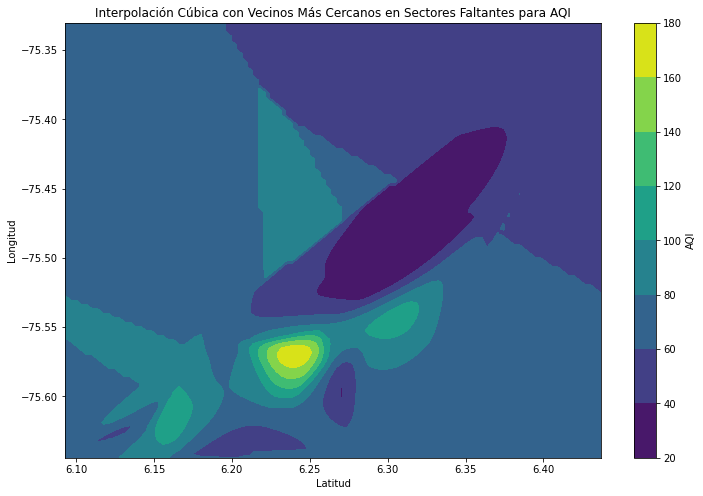

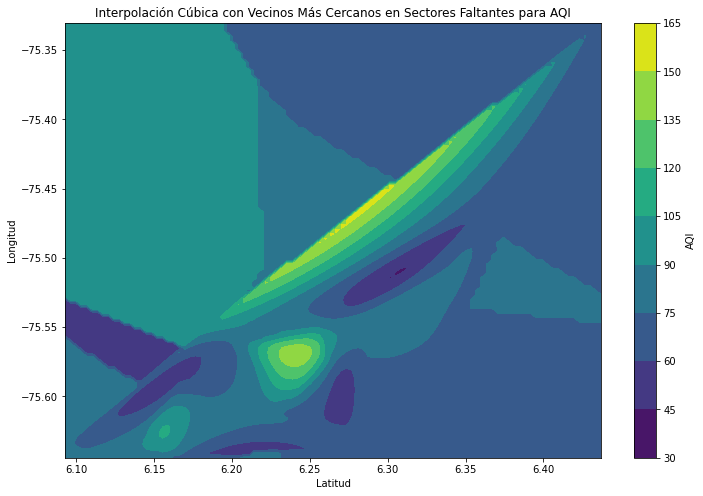

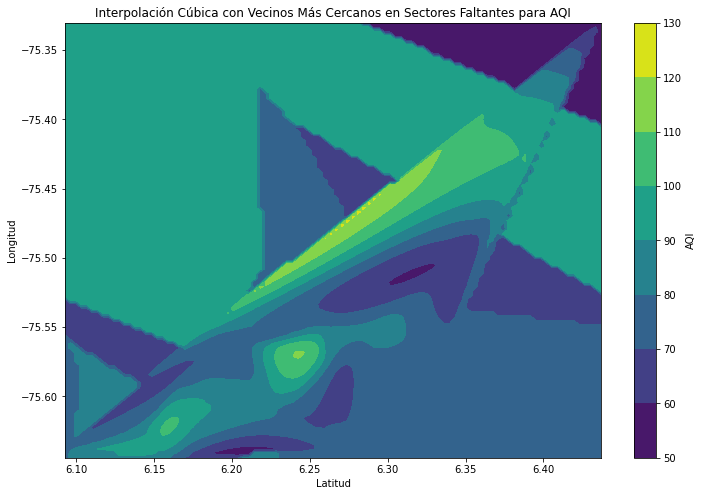

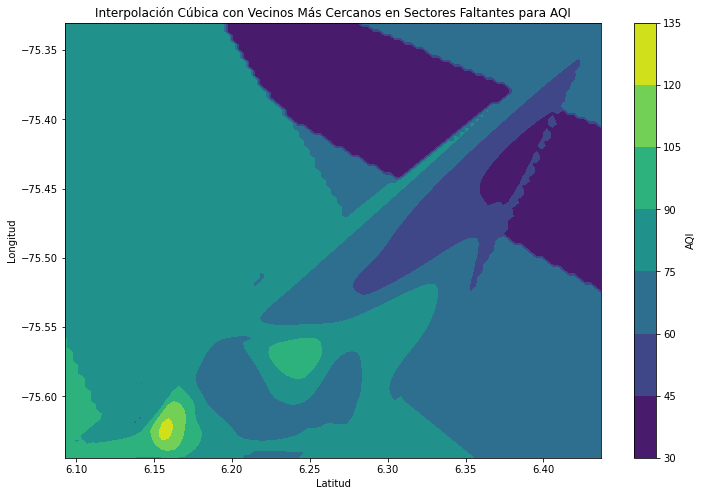

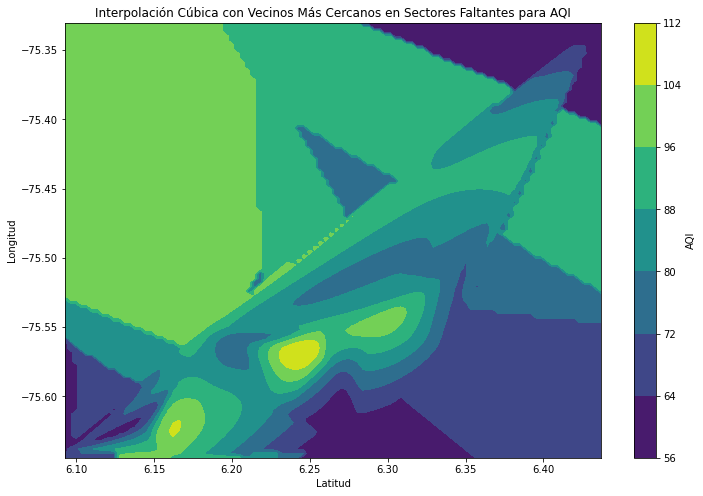

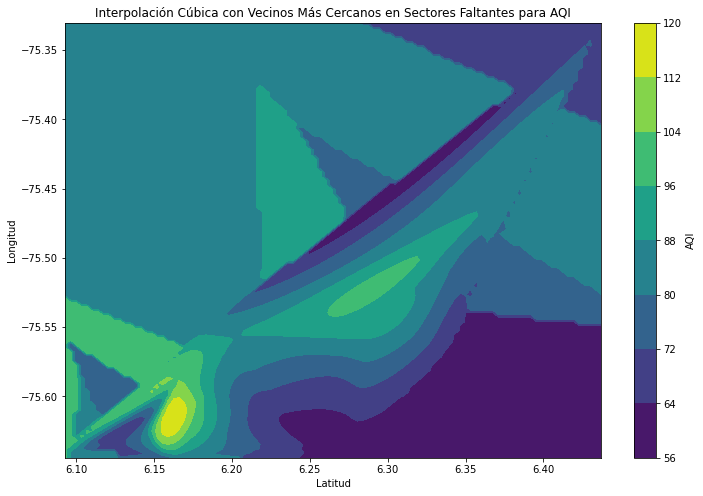

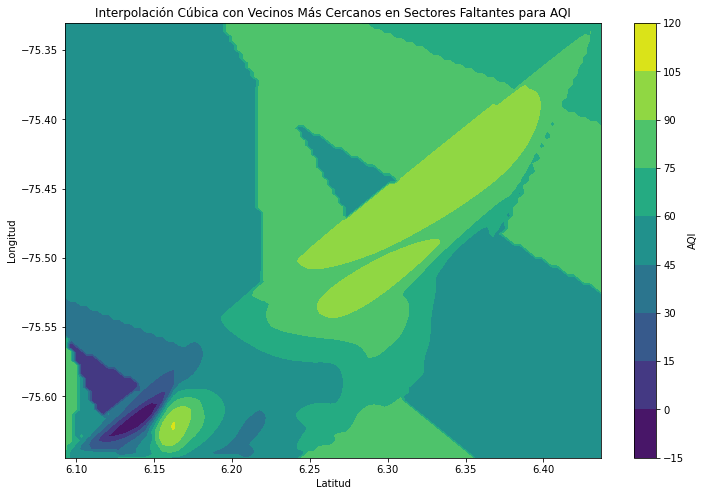

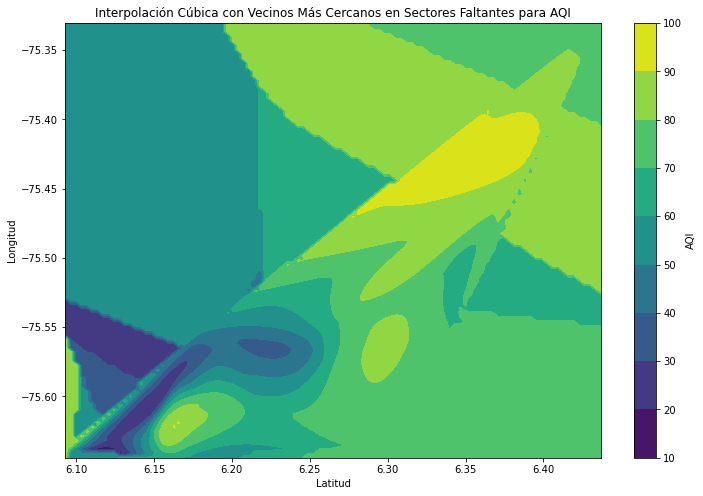

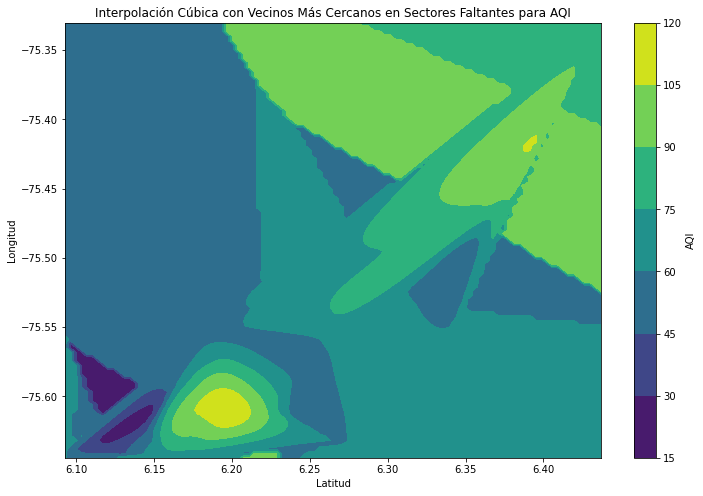

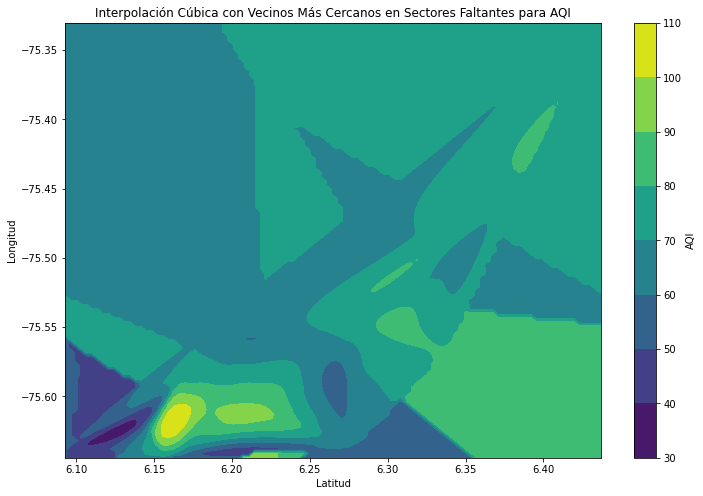

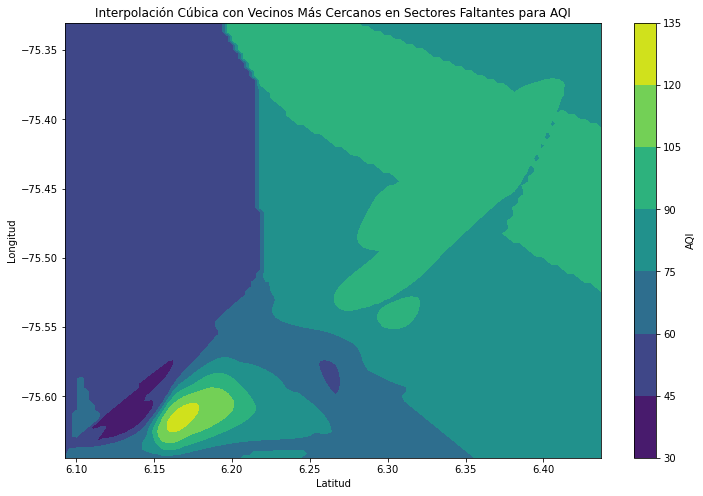

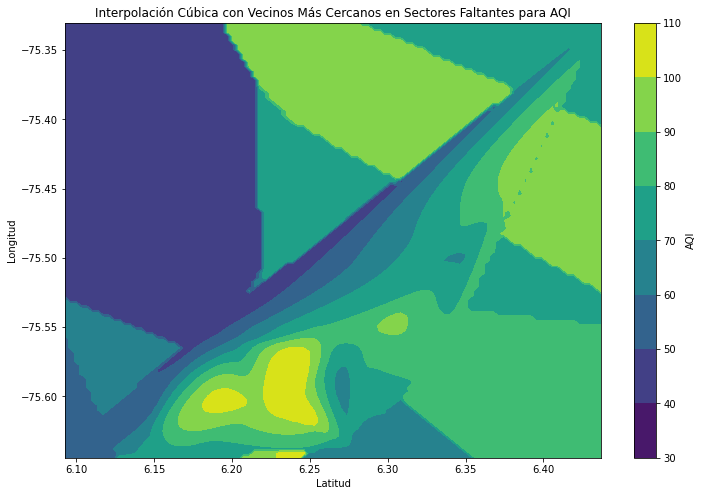

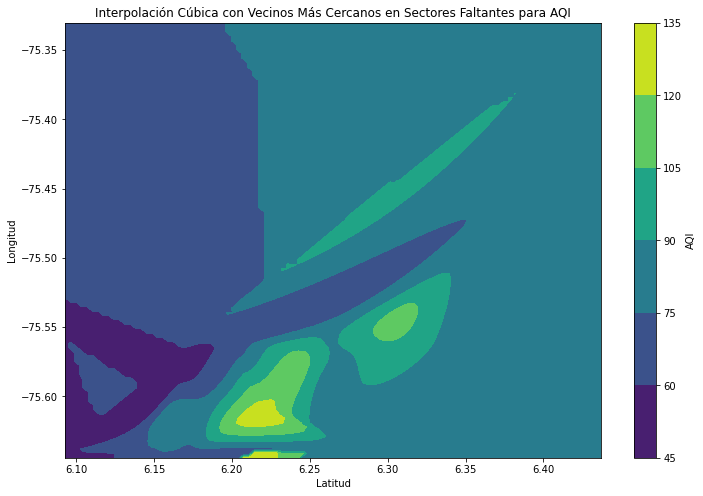

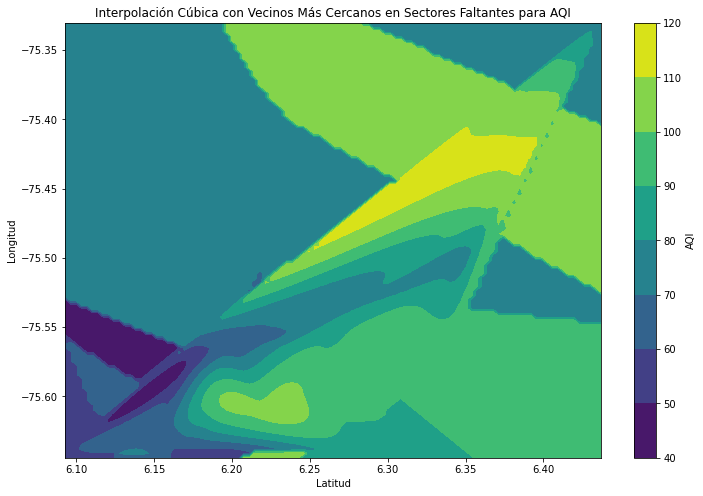

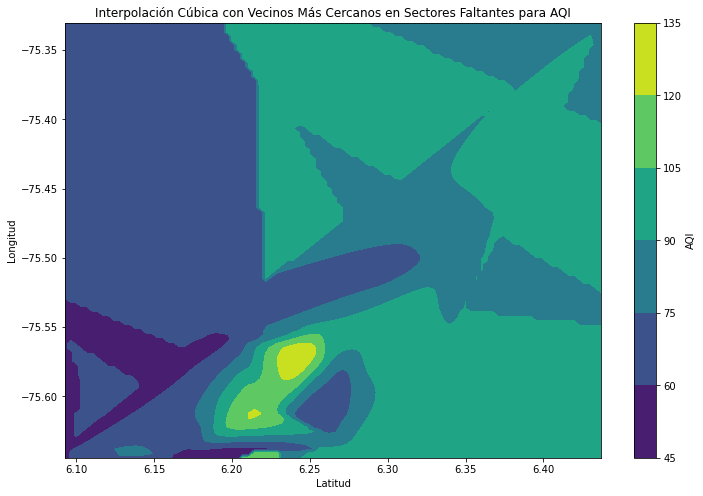

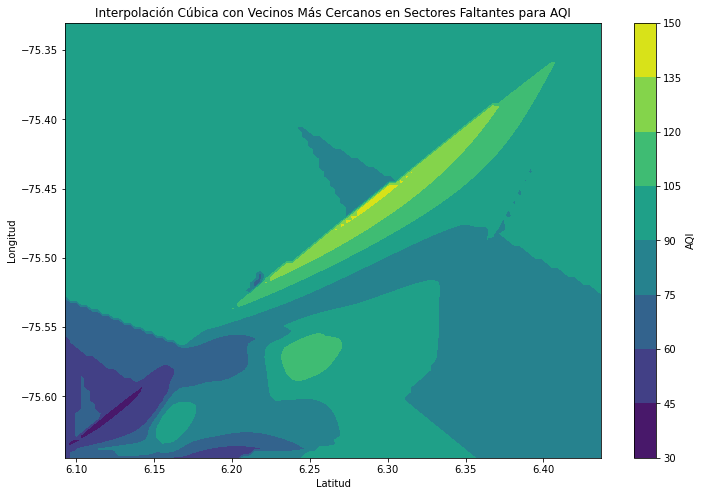

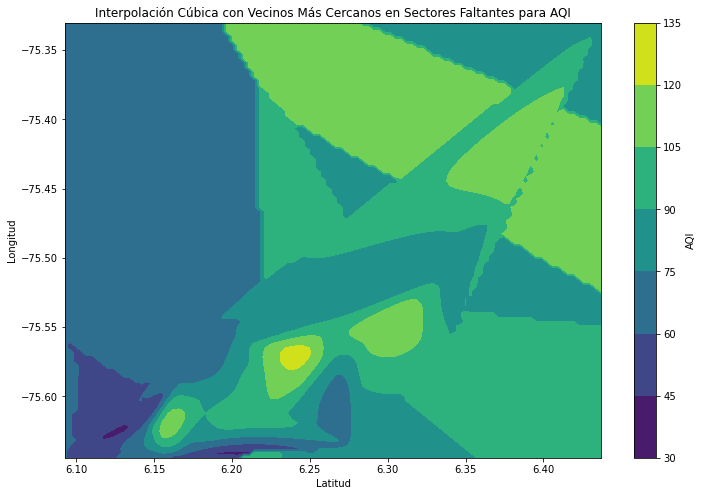

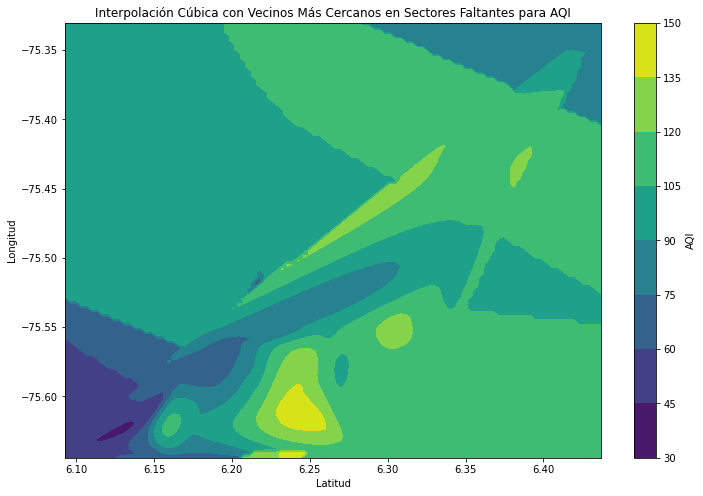

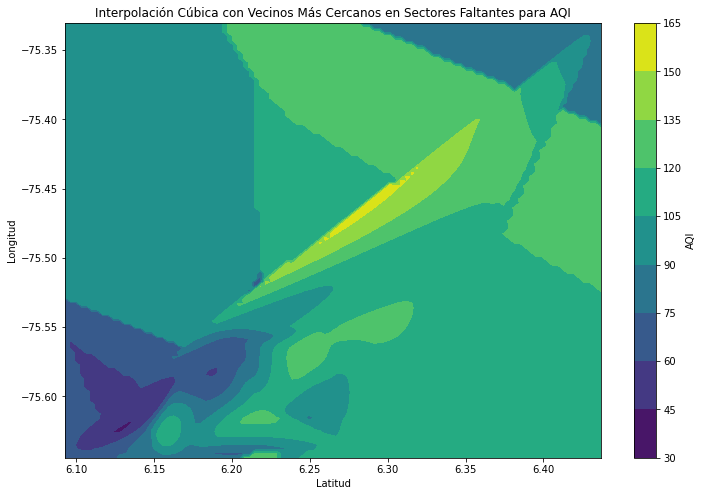

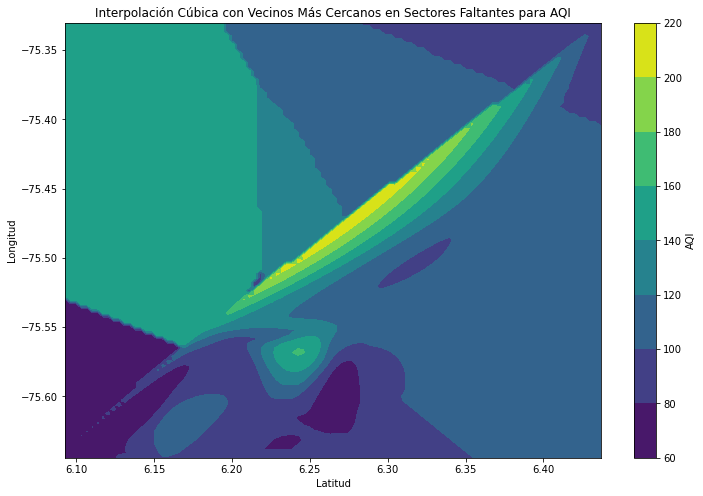

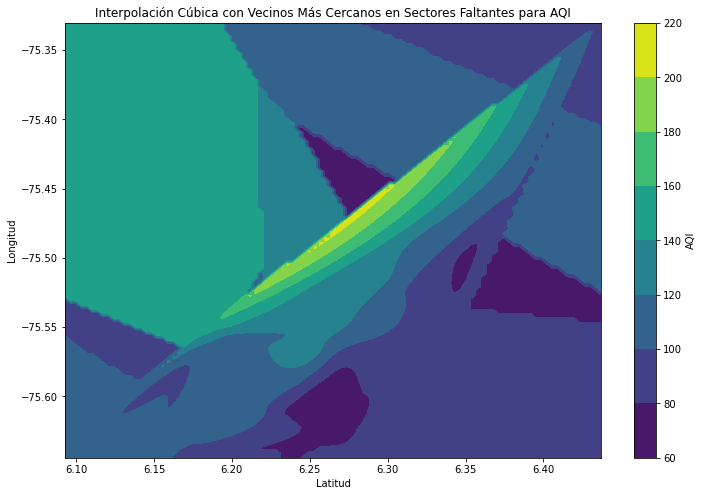

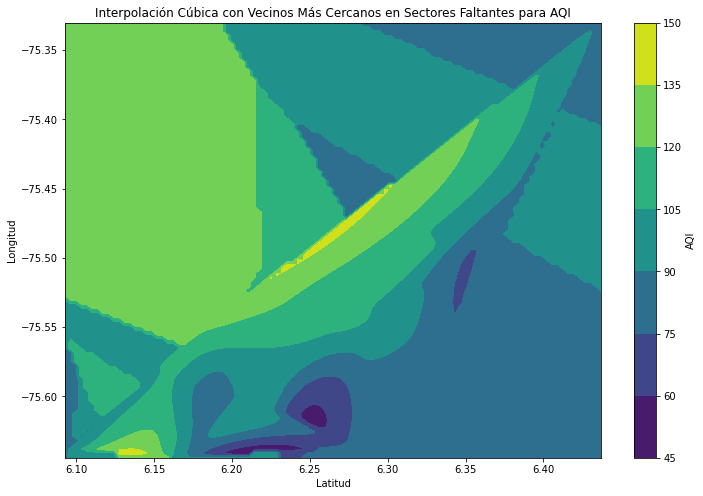

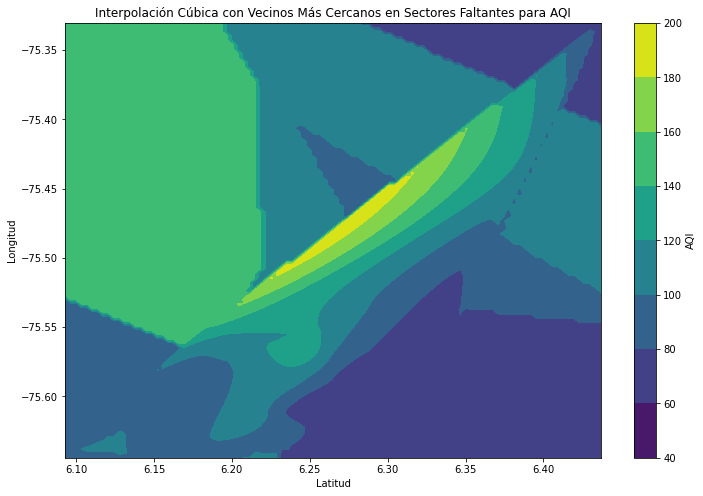

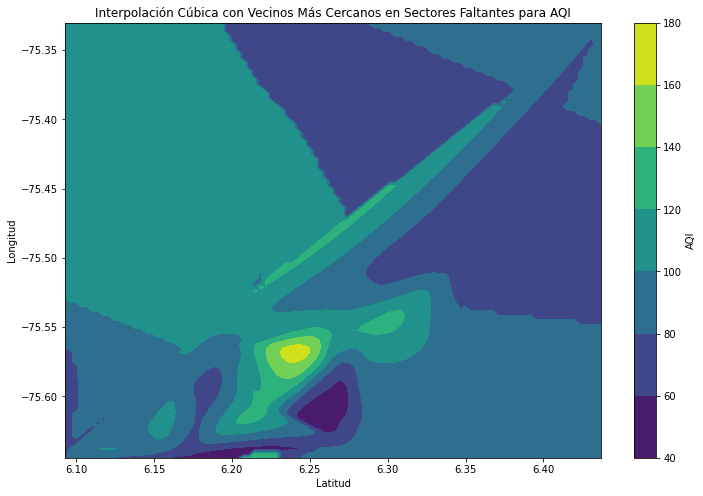

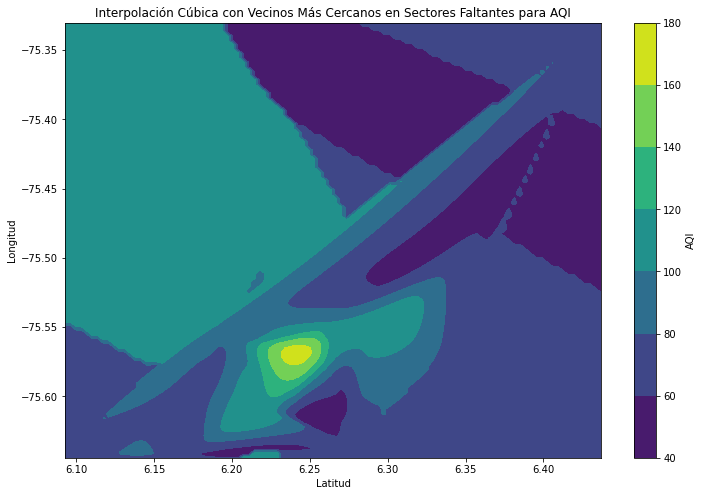

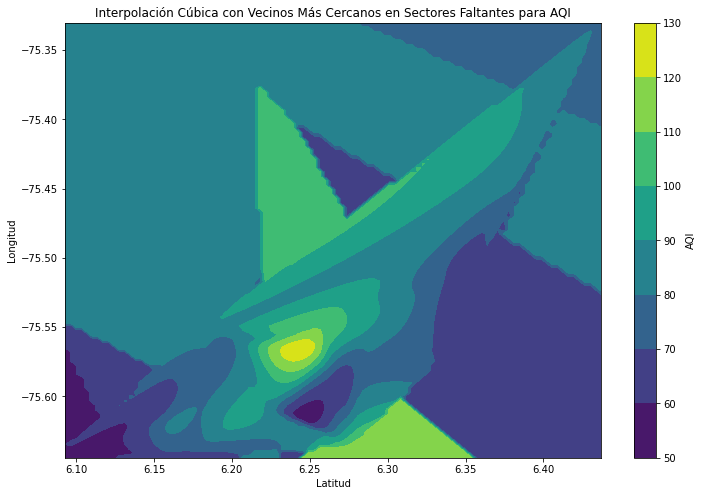

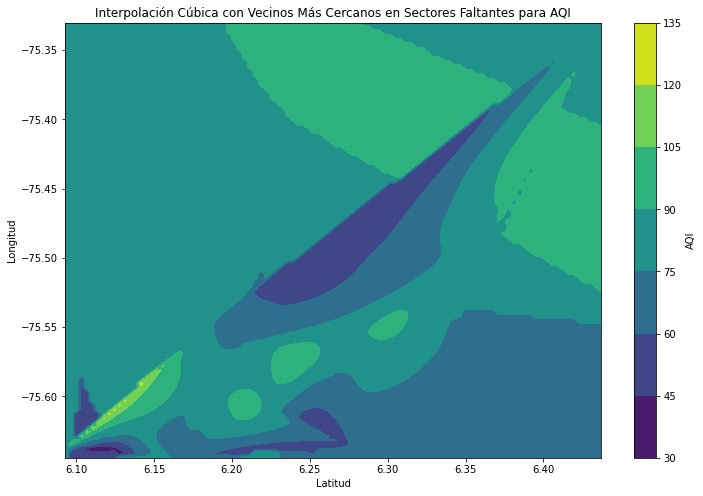

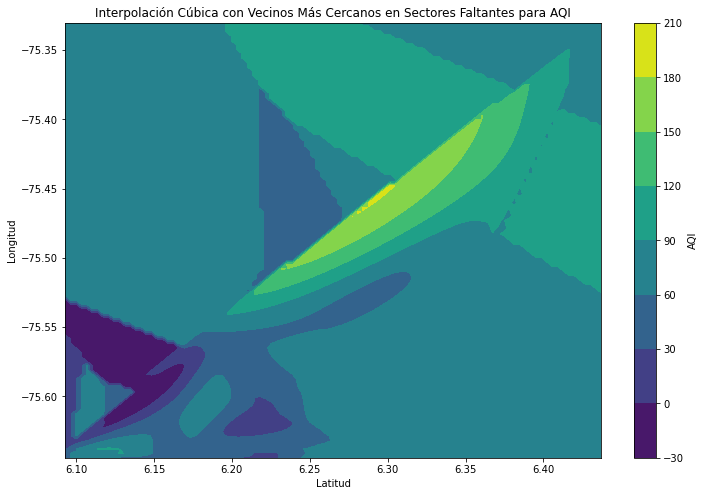

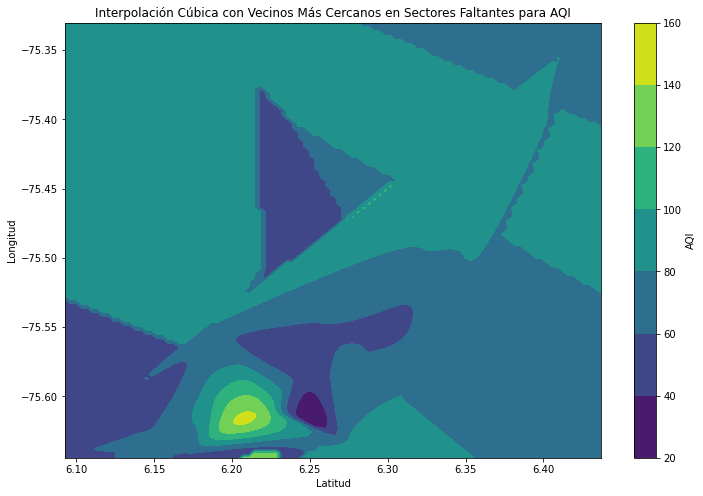

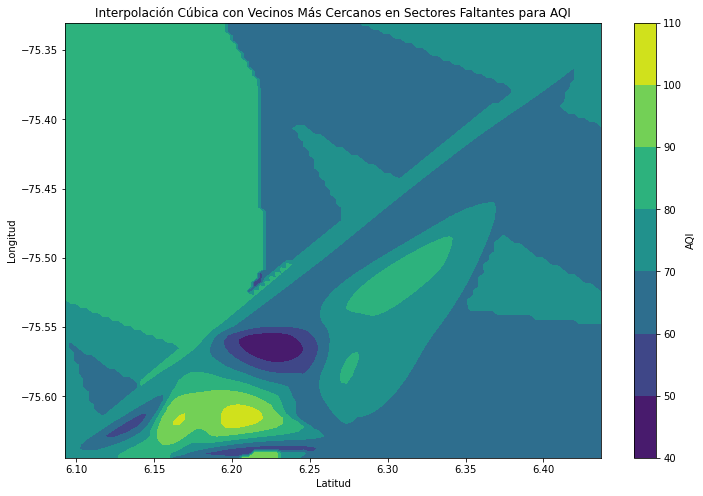

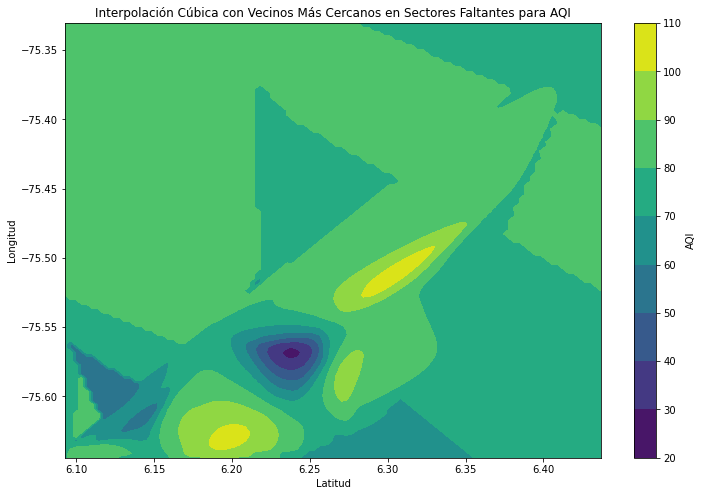

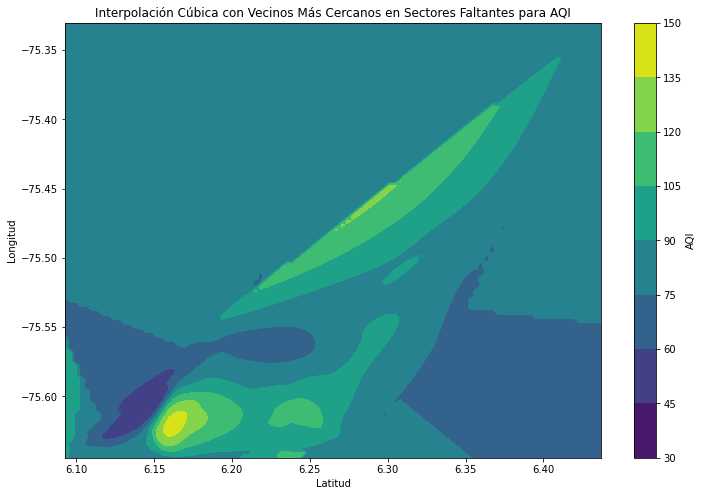

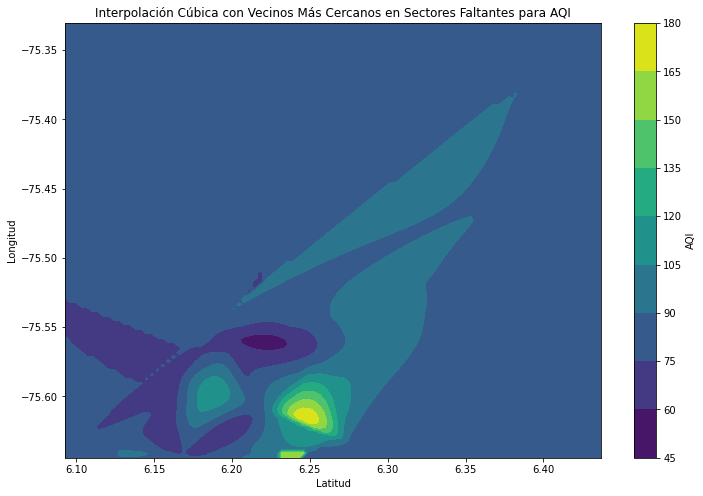

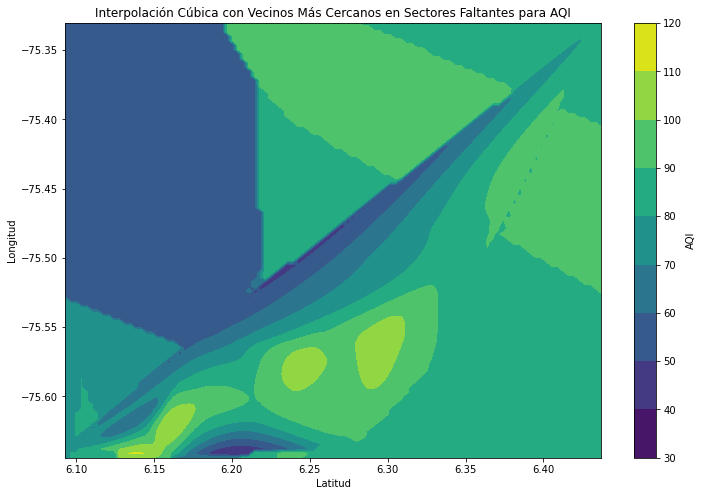

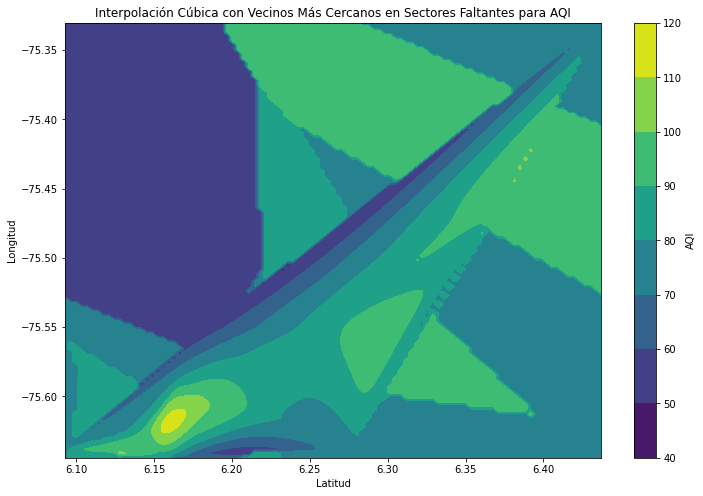

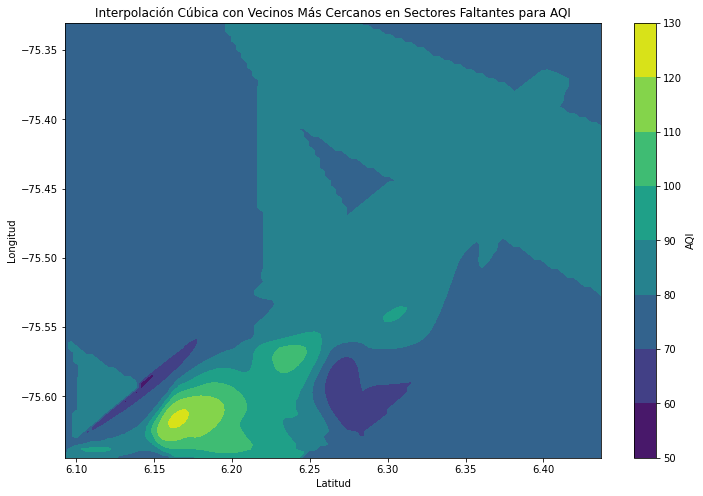

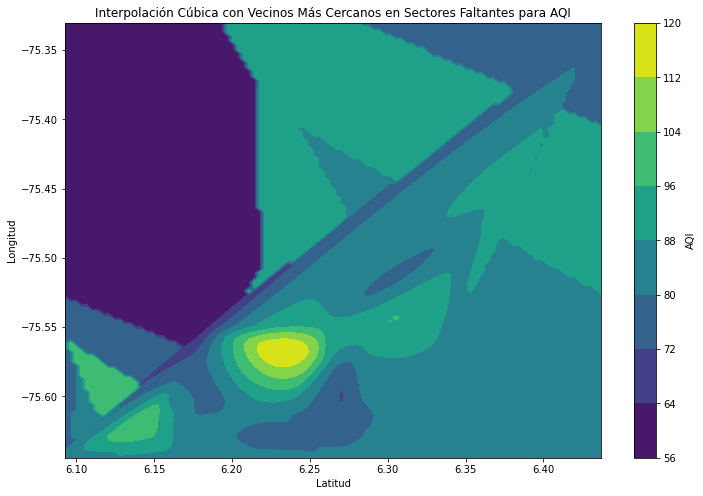

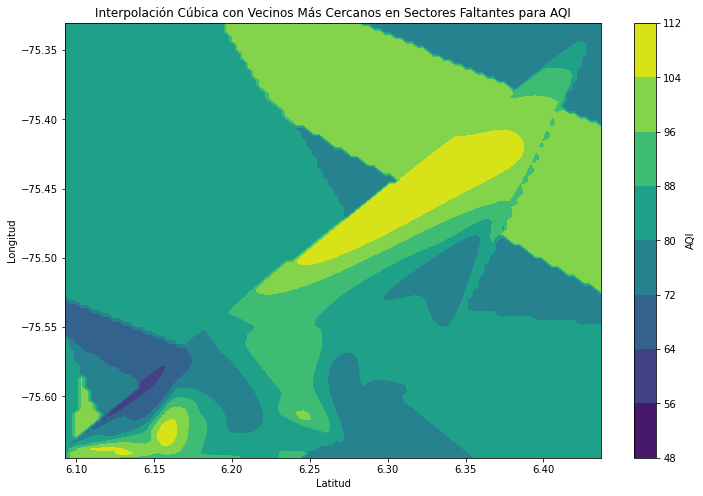

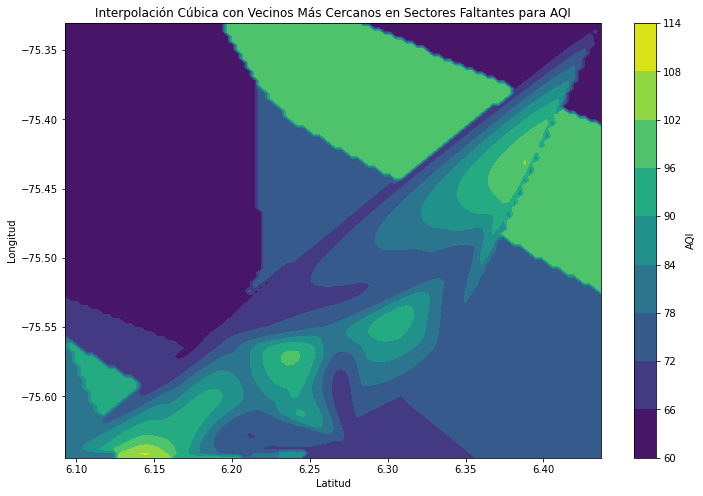

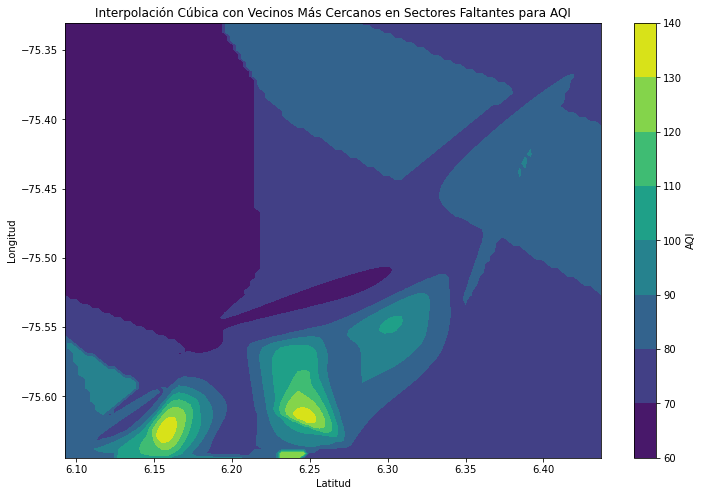

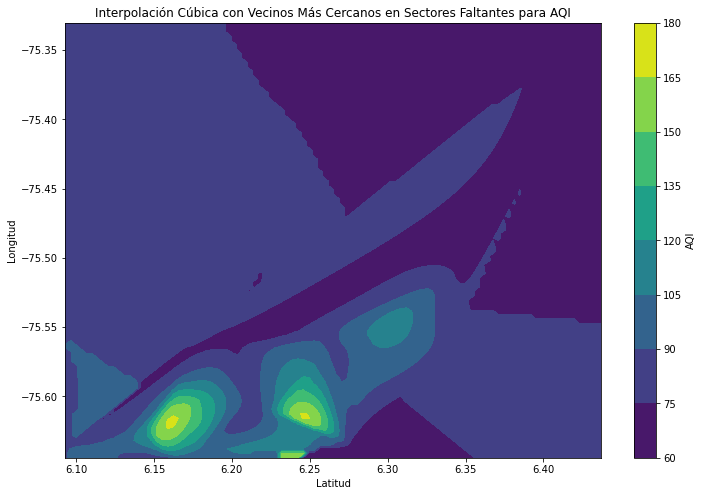

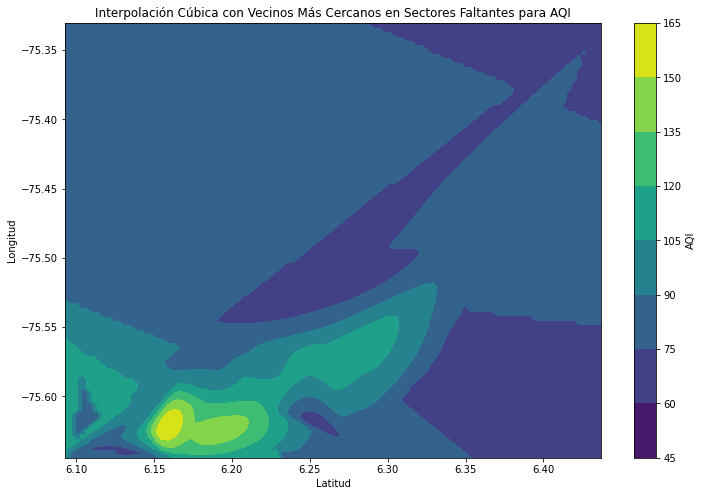

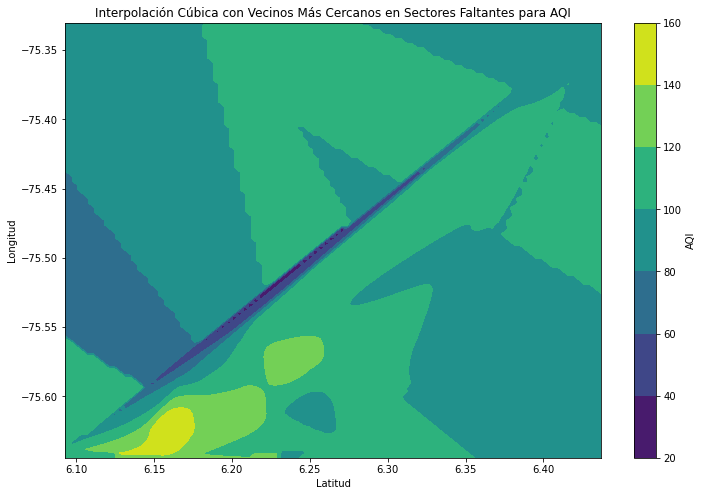

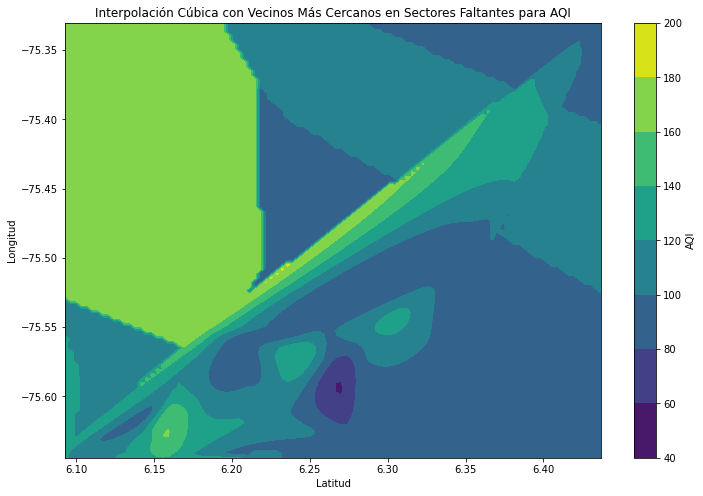

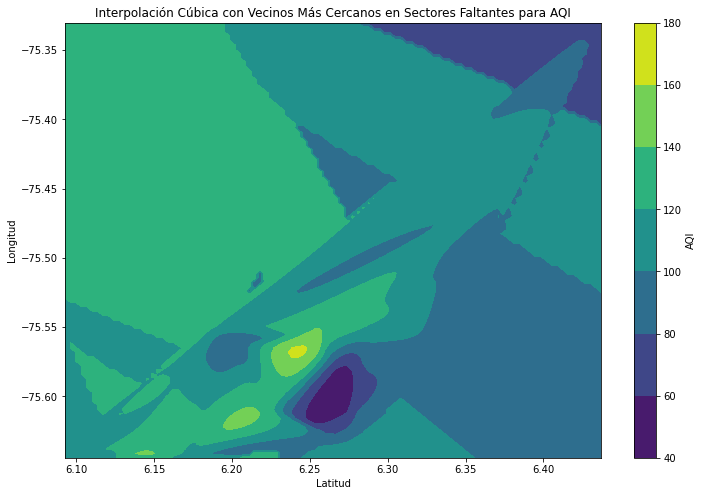

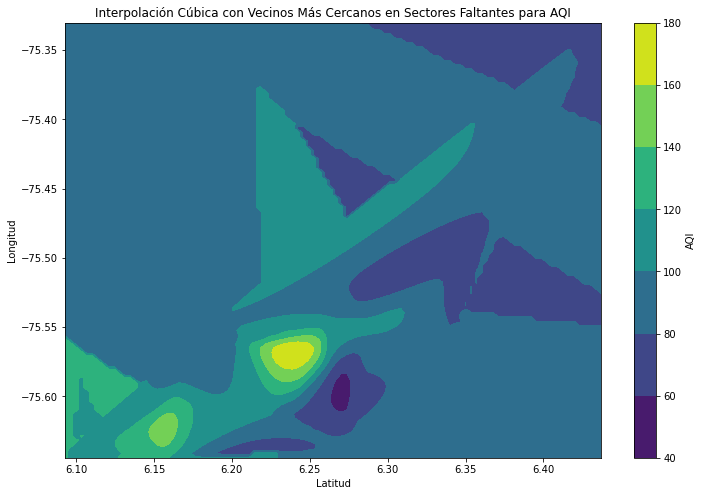

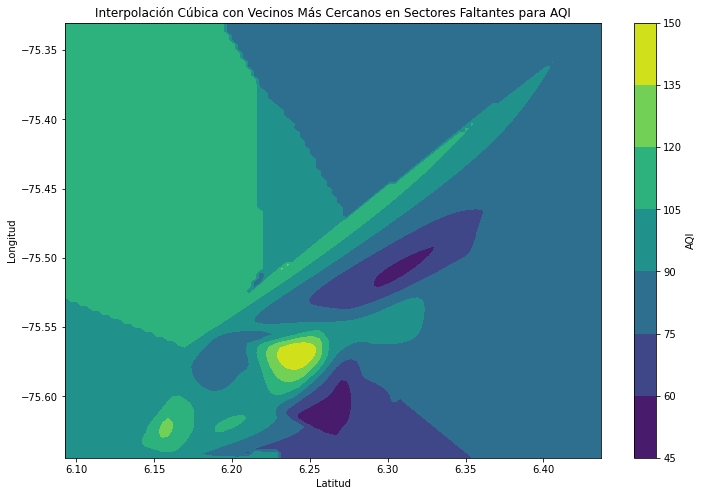

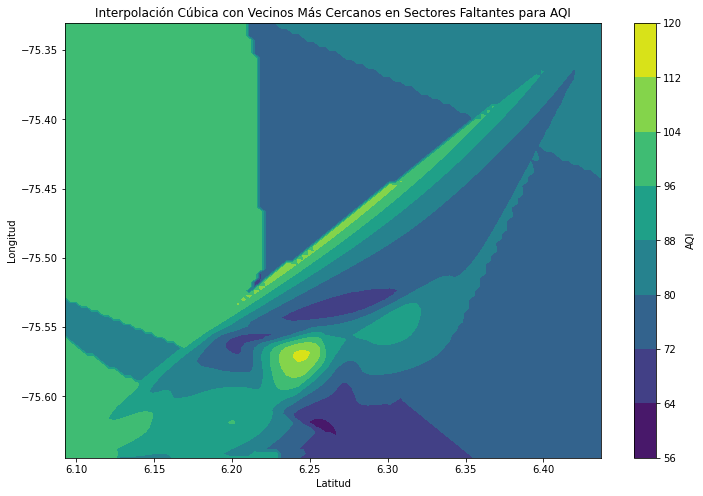

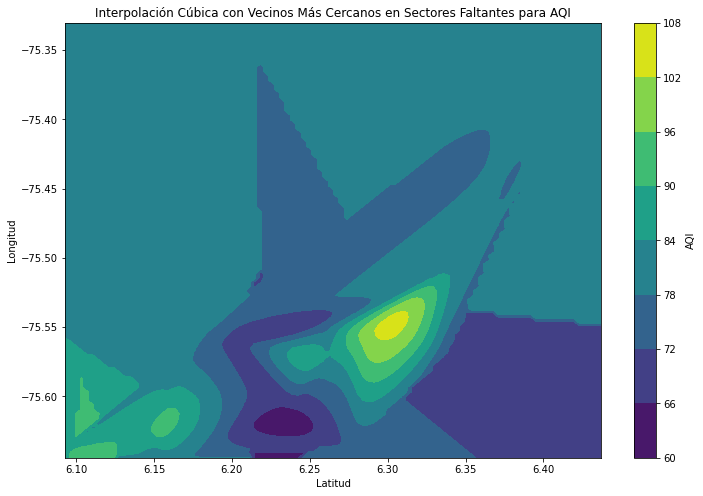

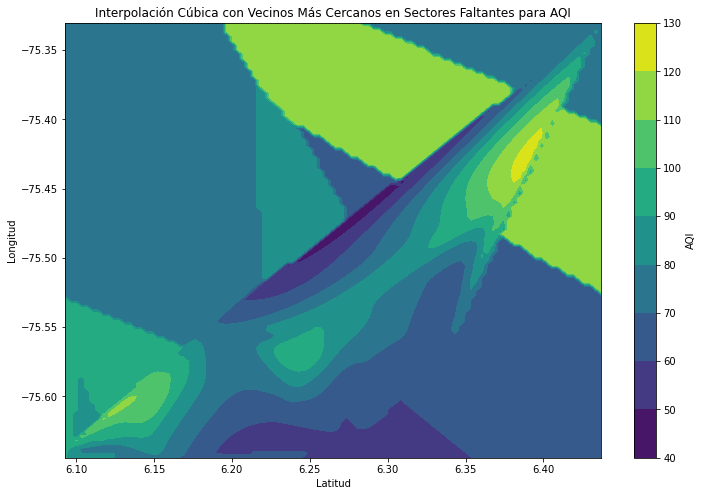

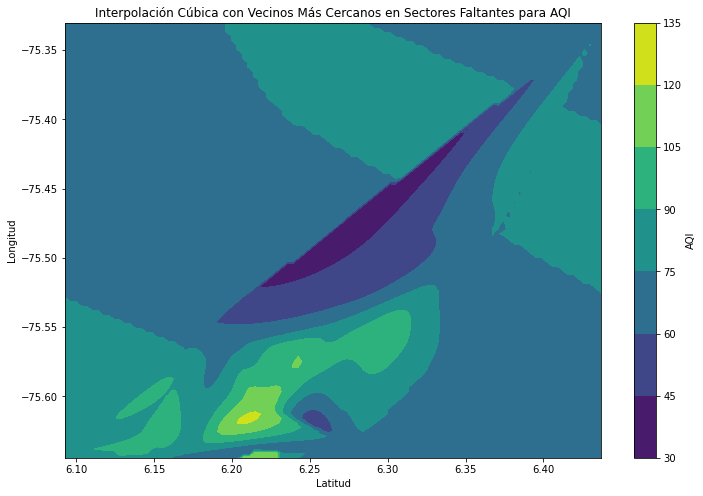

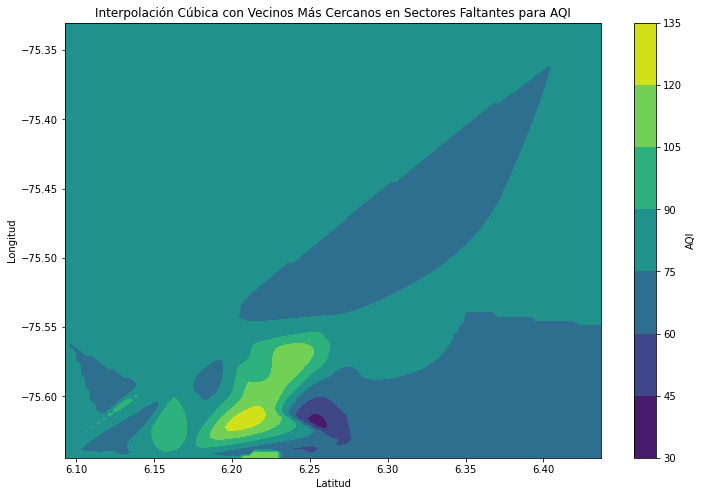

KeyboardInterrupt: 

In [188]:
for fecha in fecha_hora_unicas:
    df_hora = obtener_registros_por_hora(df_final,fecha)
    graph_aqi(df_hora)